In [37]:
import pandas as pd
import numpy as np
from math import floor
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

import datetime
import pickle
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

pd.set_option('display.max_rows', 100)

In [3]:
df = pd.read_pickle("df_clean")

df.Fecha_Prestamo=pd.to_datetime(df.Fecha_Prestamo)
df.Fecha_Devolucion=pd.to_datetime(df.Fecha_Devolucion)
df['year_prestamo'] = df.Fecha_Prestamo.dt.year
df['month_prestamo'] = df.Fecha_Prestamo.dt.month
df['day_prestamo'] = df.Fecha_Prestamo.dt.day
df['hour_prestamo'] = df.Fecha_Prestamo.dt.hour
df

Id_Historico_Prestamo  Id_Usuario  Id_Tag_Bicicleta  \
0                       6501462       18701              1164   
1                       6501318       41811              1089   
2                       6501489       96620              1110   
3                       6501001       16055              1465   
4                       6501421        6431               996   
...                         ...         ...               ...   
10387747               14454800       27944              2369   
10387748               14454778      108800              2393   
10387749               14454793       98449                60   
10387750               14454774      129665              1829   
10387751               14454588      121316              1803   

              Fecha_Prestamo    Fecha_Devolucion  Id_Aparcamiento_Origen  \
0        2017-06-21 14:22:11 2017-06-21 14:38:29                       8   
1        2017-06-21 14:07:18 2017-06-21 14:39:06                      56   
2        2017-06-21 14:25:11 2017-06-21 14:39:07                      36   
3        2017-06-21 13:35:52 2017-06-21 14:39:22                       8   
4        2017-06-21 14:17:56 2017-06-21 14:39:26                      56   
...                      ...                 ...                     ...   
10387747 2019-12-31 13:58:55 2019-12-31 14:25:38                      40   
10387748 2019-12-31 13:52:48 2019-12-31 14:40:52                      28   
10387749 2019-12-31 13:55:47 2019-12-31 14:41:39                     113   
10387750 2019-12-31 13:51:28 2019-12-31 16:27:12                      39   
10387751 2019-12-31 13:15:55 2019-12-31 15:01:31                     103   

          Posicion_Origen  Id_Aparcamiento_Destino  Posicion_Destino  \
0                       1                     43.0               1.0   
1                       6                     54.0               NaN   
2                      25                      9.0              13.0   
3                       1                      9.0               6.0   
4                      14                     54.0               NaN   
...                   ...                      ...               ...   
10387747                1                     50.0               1.0   
10387748                1                     50.0               1.0   
10387749                1                     28.0               1.0   
10387750               15                     41.0              15.0   
10387751                4                    118.0               4.0   

          operario  Num_Bici_Hist  Duration  Year_Prestamo  Year_Devolucion  \
0              161          929.0     978.0           2017             2017   
1              251         1612.0    1908.0           2017             2017   
2              273         1679.0     836.0           2017             2017   
3              273         1076.0    3810.0           2017             2017   
4              251         1176.0    1290.0           2017             2017   
...            ...            ...       ...            ...              ...   
10387747        43          541.0    1603.0           2019             2019   
10387748        43          715.0    2884.0           2019             2019   
10387749        83         3497.0    2752.0           2019             2019   
10387750       273          534.0    9344.0           2019             2019   
10387751       273         2092.0    6336.0           2019             2019   

          year_prestamo  month_prestamo  day_prestamo  hour_prestamo  
0                  2017               6            21             14  
1                  2017               6            21             14  
2                  2017               6            21             14  
3                  2017               6            21             13  
4                  2017               6            21             14  
...                 ...             ...           ...            ...  
10387

In [5]:
def eda_to_df(df):
    header="+" + ("-"*52) + "+"
    form = "+{:^16s}|{:^16s}|{:^10s}|{:^7s}|"
    print(header)
    print(form.format("Column", "Type", "Uniques", "NaN?"))
    print(header)
    for col in df.columns:
        print(form.format(str(col), str(df[col].dtypes), str(len(df[col].unique())), 
                          str(df[col].isnull().values.any()) ))
    print(header)
    
eda_to_df(df)

+----------------------------------------------------+
+     Column     |      Type      | Uniques  | NaN?  |
+----------------------------------------------------+
+Id_Historico_Prestamo|     int64      | 14221915 | False |
+   Id_Usuario   |     int64      |  93005   | False |
+Id_Tag_Bicicleta|     object     |   6698   | True  |
+ Fecha_Prestamo |     object     | 12933511 | False |
+Fecha_Devolucion|     object     | 12841682 | False |
+Id_Aparcamiento_Origen|     int64      |   128    | False |
+Posicion_Origen |     int64      |    40    | False |
+Id_Aparcamiento_Destino|    float64     |   142    | True  |
+Posicion_Destino|    float64     |    41    | True  |
+    Importe     |    float64     |    1     | False |
+DescripcionImporte|    float64     |    1     | True  |
+    operario    |     object     |   463    | True  |
+ Num_Bici_Hist  |    float64     |   2537   | True  |
+----------------------------------------------------+


Quais são as horas/dias da semana/meses mais comuns para usar uma bicicleta?

In [29]:
def plot_prestamo_over_time(df, time_unit):
    dfYear=df.groupby(time_unit+'_prestamo').size().reset_index(name='count')
    print(dfYear)
    ax = dfYear.plot(x=time_unit+"_prestamo")
    ax.locator_params(integer=True)
    return dfYear

   year_prestamo    count
0           2016  1510267
1           2017  2288567
2           2018  2792251
3           2019  3796667


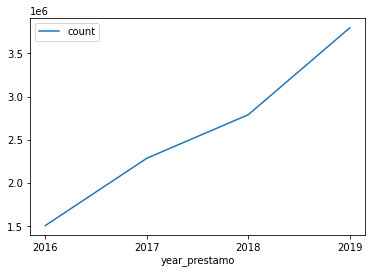

In [31]:
plot_prestamo_over_time(df, "year")

    month_prestamo    count
0                1   667607
1                2   953066
2                3   915511
3                4   752517
4                5   813120
5                6   668363
6                7   844354
7                8  1059919
8                9  1052338
9               10  1065935
10              11   884657
11              12   710365


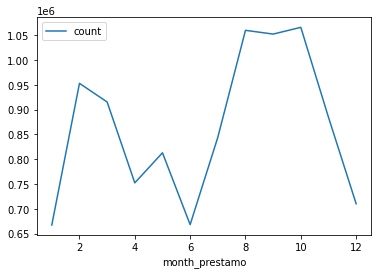

In [32]:
plot_prestamo_over_time(df, "month")

    day_prestamo   count
0              1  297618
1              2  341599
2              3  326286
3              4  338089
4              5  375815
5              6  372006
6              7  309407
7              8  342247
8              9  343406
9             10  344784
10            11  334971
11            12  366040
12            13  346292
13            14  312897
14            15  344659
15            16  359815
16            17  336824
17            18  352997
18            19  337218
19            20  307242
20            21  343125
21            22  363188
22            23  363797
23            24  317759
24            25  331810
25            26  352559
26            27  349052
27            28  339018
28            29  307114
29            30  316946
30            31  213172


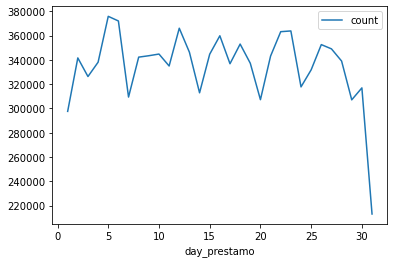

In [33]:
plot_prestamo_over_time(df, "day")

    hour_prestamo    count
0               0        1
1               1        7
2               2        3
3               3        4
4               4     1761
5               5   251400
6               6   601954
7               7   830724
8               8   574668
9               9   608485
10             10   583993
11             11   701674
12             12   761890
13             13   750609
14             14   697095
15             15   677306
16             16   809683
17             17  1060109
18             18   762157
19             19   418370
20             20   287198
21             21     4994
22             22     3652
23             23       15


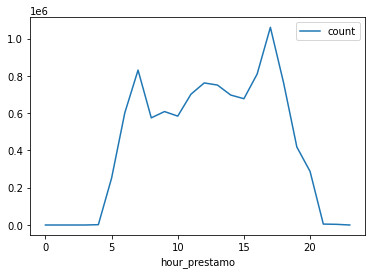

In [30]:
plot_prestamo_over_time(df, "hour")

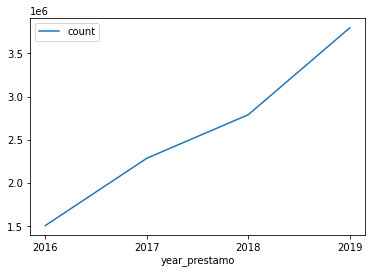

In [ ]:
Quais é que são os tempos médios de empréstimo?


In [23]:
df['duration_hour'] = (df.Fecha_Devolucion-df.Fecha_Prestamo).dt.total_seconds().div(60*60)
df

Id_Historico_Prestamo  Id_Usuario  Id_Tag_Bicicleta  \
0                       6501462       18701              1164   
1                       6501318       41811              1089   
2                       6501489       96620              1110   
3                       6501001       16055              1465   
4                       6501421        6431               996   
...                         ...         ...               ...   
10387747               14454800       27944              2369   
10387748               14454778      108800              2393   
10387749               14454793       98449                60   
10387750               14454774      129665              1829   
10387751               14454588      121316              1803   

              Fecha_Prestamo    Fecha_Devolucion  Id_Aparcamiento_Origen  \
0        2017-06-21 14:22:11 2017-06-21 14:38:29                       8   
1        2017-06-21 14:07:18 2017-06-21 14:39:06                      56   
2        2017-06-21 14:25:11 2017-06-21 14:39:07                      36   
3        2017-06-21 13:35:52 2017-06-21 14:39:22                       8   
4        2017-06-21 14:17:56 2017-06-21 14:39:26                      56   
...                      ...                 ...                     ...   
10387747 2019-12-31 13:58:55 2019-12-31 14:25:38                      40   
10387748 2019-12-31 13:52:48 2019-12-31 14:40:52                      28   
10387749 2019-12-31 13:55:47 2019-12-31 14:41:39                     113   
10387750 2019-12-31 13:51:28 2019-12-31 16:27:12                      39   
10387751 2019-12-31 13:15:55 2019-12-31 15:01:31                     103   

          Posicion_Origen  Id_Aparcamiento_Destino  Posicion_Destino  \
0                       1                     43.0               1.0   
1                       6                     54.0               NaN   
2                      25                      9.0              13.0   
3                       1                      9.0               6.0   
4                      14                     54.0               NaN   
...                   ...                      ...               ...   
10387747                1                     50.0               1.0   
10387748                1                     50.0               1.0   
10387749                1                     28.0               1.0   
10387750               15                     41.0              15.0   
10387751                4                    118.0               4.0   

          operario  Num_Bici_Hist  Duration  Year_Prestamo  Year_Devolucion  \
0              161          929.0     978.0           2017             2017   
1              251         1612.0    1908.0           2017             2017   
2              273         1679.0     836.0           2017             2017   
3              273         1076.0    3810.0           2017             2017   
4              251         1176.0    1290.0           2017             2017   
...            ...            ...       ...            ...              ...   
10387747        43          541.0    1603.0           2019             2019   
10387748        43          715.0    2884.0           2019             2019   
10387749        83         3497.0    2752.0           2019             2019   
10387750       273          534.0    9344.0           2019             2019   
10387751       273         2092.0    6336.0           2019             2019   

          year_prestamo  month_prestamo  day_prestamo  hour_prestamo  \
0                  2017               6            21             14   
1                  2017               6            21             14   
2                  2017               6            21             14   
3                  2017               6            21             13   
4                  2017               6            21             14   
...                 ...             ...           ...            ...  

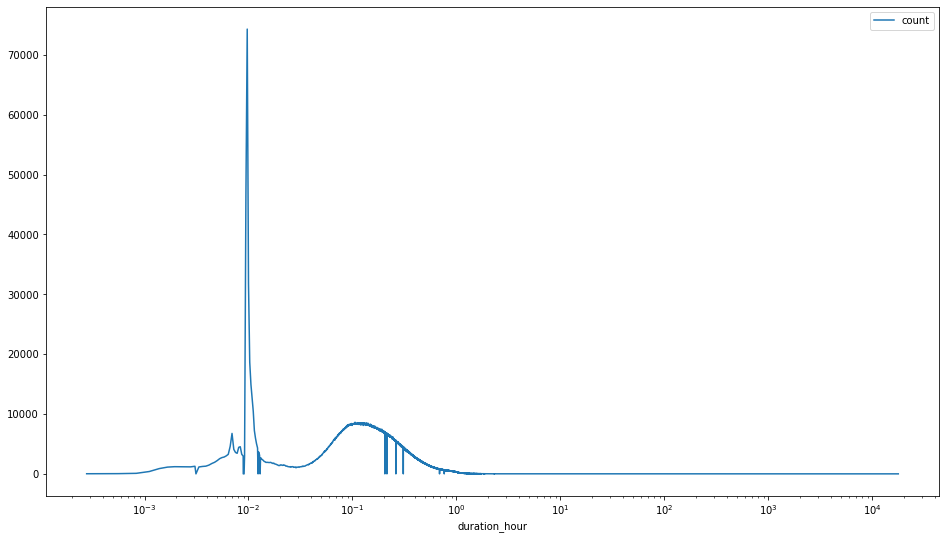

In [25]:
dfDuration=df.groupby('duration_hour').size().reset_index(name='count')
ax=dfDuration.plot(x="duration_hour", y="count", figsize=(16,9))
ax.set_xscale('log')

In [ ]:
Quais as origens/destinos mais comuns?

<AxesSubplot:xlabel='Id_Aparcamiento_Origen'>

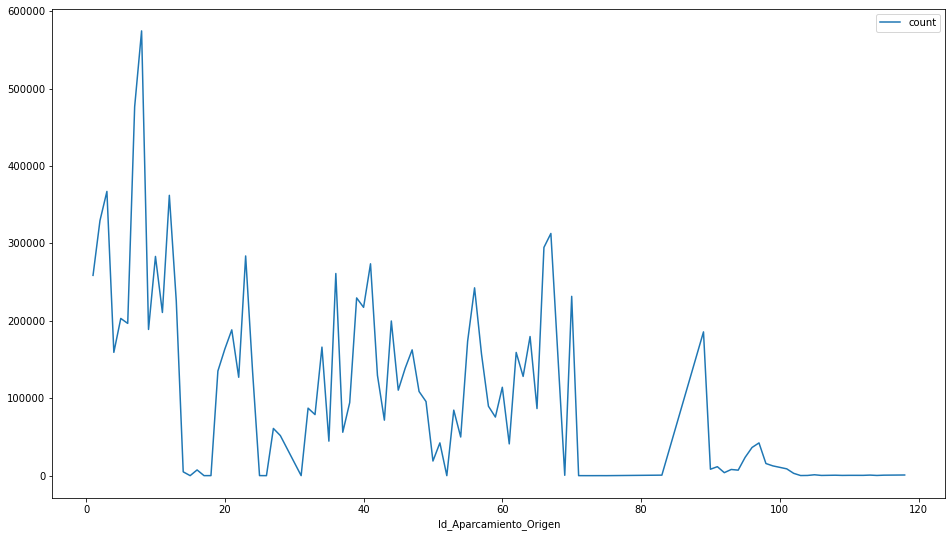

In [29]:
dfOrigin=df.groupby('Id_Aparcamiento_Origen').size().reset_index(name='count')
dfOrigin.plot(x="Id_Aparcamiento_Origen", figsize=(16,9))

<AxesSubplot:xlabel='Id_Aparcamiento_Destino'>

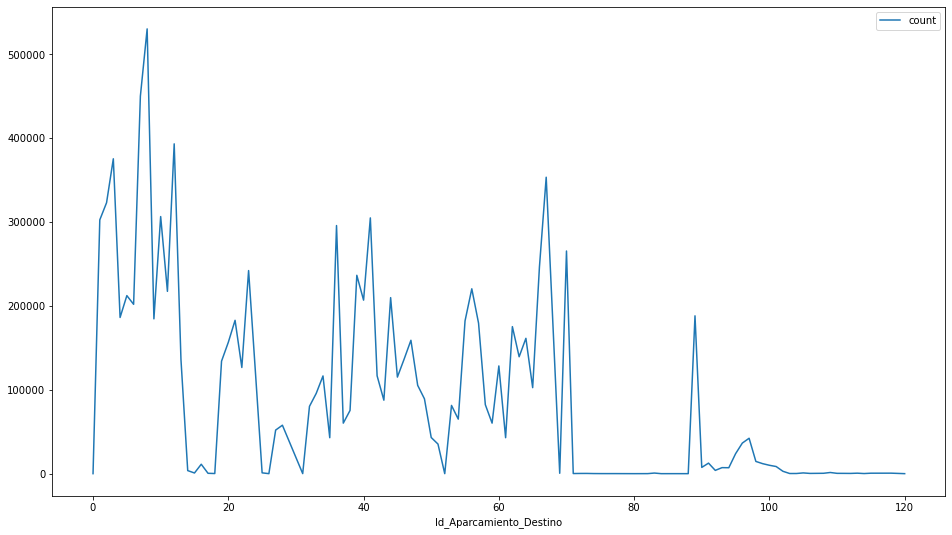

In [30]:
dfDestination=df.groupby('Id_Aparcamiento_Destino').size().reset_index(name='count')
dfDestination.plot(x="Id_Aparcamiento_Destino", figsize=(16,9))

In [ ]:
Quais os trajetos mais comuns?

In [31]:
dfTranjects=df.groupby(['Id_Aparcamiento_Origen', 'Id_Aparcamiento_Destino']).size().reset_index(name='count')
dfTranjects

Id_Aparcamiento_Origen  Id_Aparcamiento_Destino  count
0                          1                      1.0  18469
1                          1                      2.0  62067
2                          1                      3.0  28127
3                          1                      4.0   9198
4                          1                      5.0    674
...                      ...                      ...    ...
6940                     118                    112.0     12
6941                     118                    113.0     18
6942                     118                    114.0      7
6943                     118                    115.0     22
6944                     118                    118.0    189

[6945 rows x 3 columns]

<ipython-input-54-fd3694564fd7>:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


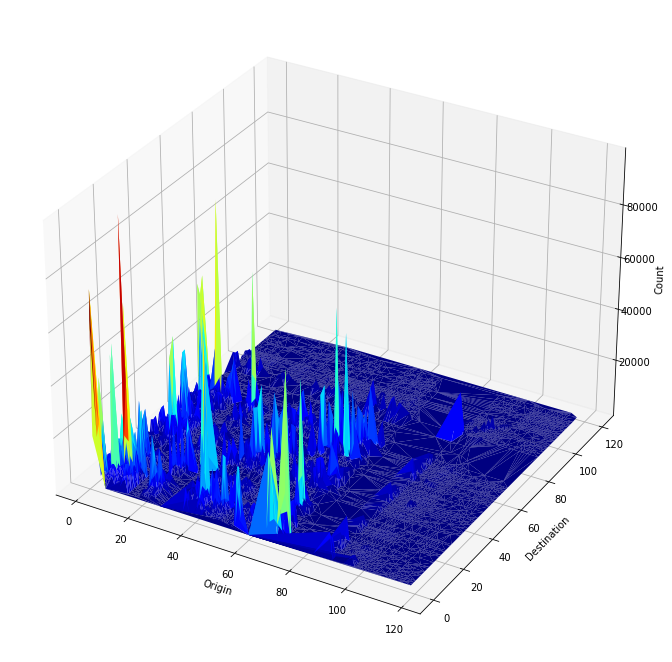

In [54]:
fig = plt.figure(figsize=(16, 9))
ax = Axes3D(fig)

ax.plot_trisurf(dfTranjects["Id_Aparcamiento_Origen"], dfTranjects["Id_Aparcamiento_Destino"], dfTranjects["count"], cmap=cm.jet, linewidth=0.2)
ax.set_zlabel('Count')
ax.set_xlabel('Origin')
ax.set_ylabel('Destination')

plt.show()

In [4]:
df['Fecha_Prestamo_htruncate'] = df['Fecha_Prestamo'].dt.floor('h')
unique_parks = df['Id_Aparcamiento_Origen'].unique()
unique_parks

array([  8,  56,  36,  22,  19,  21,  47,  45,  46,  65,  39,  55,  11,
        44,   2,  62,  10,   3,  34,  41,   6,  43,  58,  38,   7,  67,
        13,  60,  23,  40,  63,  66,   1,   4,   9,  51,  12,  70,  69,
        24,  16,  64,  59,  33,  42,  57,  27,  61,  48,  20,  35,  37,
         5,  32,  49,  54,  28,  53,  17,  14,  52,  31,  25,  15,  89,
        26,  50,  83,  72,  74,  71,  73,  75,  91,  94,  90,  18,  97,
        95,  96,  93,  98, 100,  99, 101, 102,  92, 113, 109, 108, 118,
       114, 105, 112, 111, 103, 104, 115, 106, 110])

In [7]:
dfOrigemDayCount=df.groupby(["Id_Aparcamiento_Origen", pd.Grouper(key="Fecha_Prestamo_htruncate", freq="D")]).size().reset_index(name='Count')
dfOrigemDayCount

Id_Aparcamiento_Origen Fecha_Prestamo_htruncate  Count
0                           1               2016-01-04     71
1                           1               2016-01-05     85
2                           1               2016-01-06     71
3                           1               2016-01-07     97
4                           1               2016-01-08     87
...                       ...                      ...    ...
63781                     118               2019-12-26     32
63782                     118               2019-12-27     18
63783                     118               2019-12-28     28
63784                     118               2019-12-30     24
63785                     118               2019-12-31      6

[63786 rows x 3 columns]

In [6]:
def generate_features(df, cols, distance=1, count_before=3, offset=0):
    # Filter rows in which we cannot trace back history
    periodDf = df[df.index-(count_before*distance+offset)>=0].copy()
    # Number of removed elements is the offset for the new df
    n_removed=df.shape[0]-periodDf.shape[0]
    # Add new features based on traced history
    for col in cols:
        for i in range(0, count_before):
            diff=(i+1)*distance+offset
            periodDf[col+"_minus_" + str(diff)]=periodDf.apply(lambda row: df.iloc[int(row.name)-diff][col], axis=1) 
        
    return periodDf

def prepare_inputs(X_train, X_test):
    ohe = OneHotEncoder()
    ohe.fit(X_train)
    X_train_enc = ohe.transform(X_train)
    X_test_enc = ohe.transform(X_test)
    return X_train_enc, X_test_enc


def split_df(df, train_size=0.8):
    train_size = floor(df.shape[0]*train_size)

    train = df[:train_size]
    test = df[train_size:]
    
    return train, test

def process_df(train, test):
    trainX = train[dfFeatures.columns[4:]]
    trainX = trainX.to_numpy().reshape(trainX.shape[0], trainX.shape[1], 1)
    trainY = train[["Count"]]
    trainY = trainY.to_numpy().reshape(trainY.shape[0])
    testX = test[dfFeatures.columns[4:]]
    testX = testX.to_numpy().reshape(testX.shape[0], testX.shape[1], 1)
    testY = test[["Count"]]
    testY = testY.to_numpy().reshape(testY.shape[0])
    
    
    return trainX, trainY, testX, testY

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[0], trainX.shape[1], trainX.shape[2]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_features, n_outputs)))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return model, accuracy


def run_experiment(trainX, trainy, testX, testy, repeats=10):
    min_score=-1
    min_model=None
    # repeat experiment
    scores = list()
    for r in range(repeats):
        print("Train #{}....".format(r))
        model, score = evaluate_model(trainX, trainy, testX, testy)
        if min_score==-1 or score<min_score:
            min_score=score
            min_model=model
        scores.append(score)
    return min_model, scores

In [33]:
allNodesDf=pd.DataFrame()
# CREATE MODEL PER NODE AND PREDICT TEST SET BASED ON EACH INDIVIDUAL MODEL
for park in unique_parks:
    # FILTERING ENTRIES TO PARK ID
    print ("Filtering entries by park id {}...".format(park))
    dfParkId = dfOrigemDayCount[dfOrigemDayCount.Id_Aparcamiento_Origen==park]
    dfParkId=dfParkId.reset_index()
    
    # GENERATE FEATURES (4 ENTRIES 7 DAYS APPART FROM EACH OTHER FROM THE PREVIOUS 4 WEEKS)
    print ("Generating park {} features...".format(park))
    dfFeatures=generate_features(dfParkId, ["Count"], distance=7, count_before=4, offset=7)
    dfFeatures=dfFeatures.reset_index(drop=True)

    # SPLITTING DF INTO TRAIN AND TEST SETS
    print ("Splitting train/test dataset for park id {}...".format(park))
    train, test = split_df(dfFeatures)
    trainX, trainy, testX, testy = process_df(train, test)
    
    # TRAIN CNN
    print ("Traning model for park id {}...".format(park))
    model, scores = run_experiment(trainX, trainy, testX, testy, repeats=3)
    
    # PREDICT TEST SET SAMPLES
    print ("Predicting samples for park id {}...".format(park))
    predict = model.predict(testX)
    dfPredict=pd.DataFrame(data=predict.flatten()[:], columns=["predict"])
    truth=pd.DataFrame(data=testy[:], columns=["truth"])
    testDf=pd.concat([dfPredict, truth, test.reset_index()[["Id_Aparcamiento_Origen", "Fecha_Prestamo_htruncate"]]], axis=1)
    testDf.set_index(["Id_Aparcamiento_Origen", "Fecha_Prestamo_htruncate"], inplace = True)
    allNodesDf=pd.concat([allNodesDf, testDf])
    print(allNodesDf)

Filtering entries by park id 8...
Generating park 8 features...
Splitting train/test dataset for park id 8...
Traning model for park id 8...
Train #0....
Train #1....
Train #2....
Predicting samples for park id 8...
                                                    predict  truth
Id_Aparcamiento_Origen Fecha_Prestamo_htruncate                   
8                      2019-04-13                635.103149    422
                       2019-04-15                701.618286    531
                       2019-04-16                757.048340    495
                       2019-04-17                745.330994    457
                       2019-04-22                884.437317    604
...                                                     ...    ...
                       2019-12-26                623.361267    372
                       2019-12-27                569.527649    392
                       2019-12-28                551.139893    224
                       2019-12-30              

Splitting train/test dataset for park id 46...
Traning model for park id 46...
Train #0....
Train #1....
Train #2....
Predicting samples for park id 46...
                                                    predict  truth
Id_Aparcamiento_Origen Fecha_Prestamo_htruncate                   
8                      2019-04-13                635.103149    422
                       2019-04-15                701.618286    531
                       2019-04-16                757.048340    495
                       2019-04-17                745.330994    457
                       2019-04-22                884.437317    604
...                                                     ...    ...
46                     2019-12-26                143.900345    121
                       2019-12-27                139.398651    136
                       2019-12-28                141.043762     66
                       2019-12-30                161.202957    107
                       2019-12-31        

Splitting train/test dataset for park id 10...
Traning model for park id 10...
Train #0....
Train #1....
Train #2....
Predicting samples for park id 10...
                                                    predict  truth
Id_Aparcamiento_Origen Fecha_Prestamo_htruncate                   
8                      2019-04-13                635.103149    422
                       2019-04-15                701.618286    531
                       2019-04-16                757.048340    495
                       2019-04-17                745.330994    457
                       2019-04-22                884.437317    604
...                                                     ...    ...
10                     2019-12-26                219.170929    105
                       2019-12-27                198.898926    126
                       2019-12-28                189.280701     82
                       2019-12-30                174.226776    101
                       2019-12-31        

Splitting train/test dataset for park id 7...
Traning model for park id 7...
Train #0....
Train #1....
Train #2....
Predicting samples for park id 7...
                                                    predict  truth
Id_Aparcamiento_Origen Fecha_Prestamo_htruncate                   
8                      2019-04-13                635.103149    422
                       2019-04-15                701.618286    531
                       2019-04-16                757.048340    495
                       2019-04-17                745.330994    457
                       2019-04-22                884.437317    604
...                                                     ...    ...
7                      2019-12-26                476.463196    323
                       2019-12-27                471.196991    330
                       2019-12-28                444.571655    174
                       2019-12-30                439.173553    282
                       2019-12-31           

Splitting train/test dataset for park id 1...
Traning model for park id 1...
Train #0....
Train #1....
Train #2....
Predicting samples for park id 1...
                                                    predict  truth
Id_Aparcamiento_Origen Fecha_Prestamo_htruncate                   
8                      2019-04-13                635.103149    422
                       2019-04-15                701.618286    531
                       2019-04-16                757.048340    495
                       2019-04-17                745.330994    457
                       2019-04-22                884.437317    604
...                                                     ...    ...
1                      2019-12-26                  0.000000    268
                       2019-12-27                  0.000000    282
                       2019-12-28                  0.000000    214
                       2019-12-30                  0.000000    269
                       2019-12-31           

Splitting train/test dataset for park id 24...
Traning model for park id 24...
Train #0....
Train #1....
Train #2....
Predicting samples for park id 24...
                                                    predict  truth
Id_Aparcamiento_Origen Fecha_Prestamo_htruncate                   
8                      2019-04-13                635.103149    422
                       2019-04-15                701.618286    531
                       2019-04-16                757.048340    495
                       2019-04-17                745.330994    457
                       2019-04-22                884.437317    604
...                                                     ...    ...
24                     2019-12-26                154.835938    159
                       2019-12-27                177.684265    165
                       2019-12-28                171.640244    103
                       2019-12-30                178.412231    152
                       2019-12-31        

Splitting train/test dataset for park id 57...
Traning model for park id 57...
Train #0....
Train #1....
Train #2....
Predicting samples for park id 57...
                                                    predict  truth
Id_Aparcamiento_Origen Fecha_Prestamo_htruncate                   
8                      2019-04-13                635.103149    422
                       2019-04-15                701.618286    531
                       2019-04-16                757.048340    495
                       2019-04-17                745.330994    457
                       2019-04-22                884.437317    604
...                                                     ...    ...
57                     2019-12-26                148.041794    161
                       2019-12-27                159.399094    139
                       2019-12-28                162.659760     89
                       2019-12-30                147.009415    144
                       2019-12-31        

Splitting train/test dataset for park id 32...
Traning model for park id 32...
Train #0....
Train #1....
Train #2....
Predicting samples for park id 32...
                                                    predict  truth
Id_Aparcamiento_Origen Fecha_Prestamo_htruncate                   
8                      2019-04-13                635.103149    422
                       2019-04-15                701.618286    531
                       2019-04-16                757.048340    495
                       2019-04-17                745.330994    457
                       2019-04-22                884.437317    604
...                                                     ...    ...
32                     2019-12-26                 77.159538     53
                       2019-12-27                 82.681190     53
                       2019-12-28                 72.652557     25
                       2019-12-30                 94.745720     39
                       2019-12-31        

ValueError: Wrong number of items passed 4, placement implies 1

# Overall results

OVERALL ROOT MEAN SQUARED ERROR >> 90.62318012706277
 ------------------ NODE 8 TRUTH VS PREDICTED CHECK INS ------------------ 


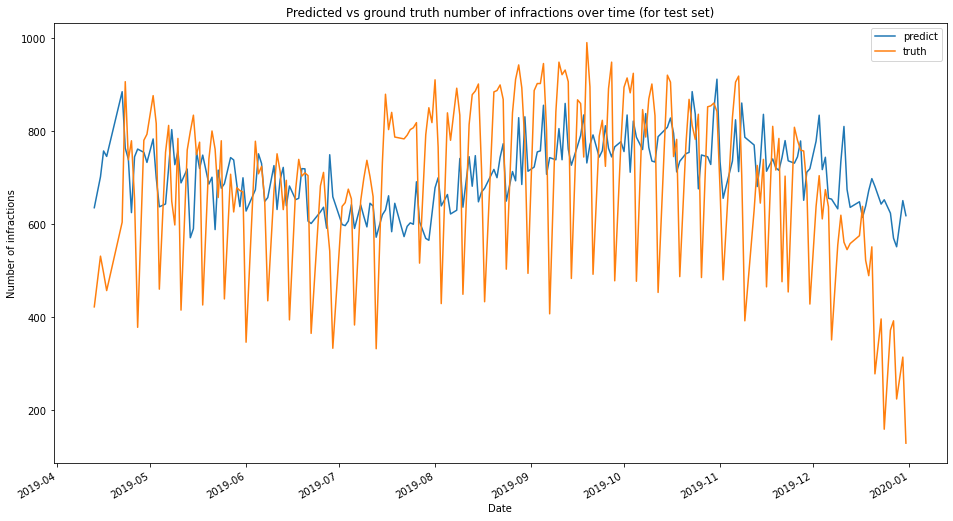

 ------------------ NODE 56 TRUTH VS PREDICTED CHECK INS ------------------ 


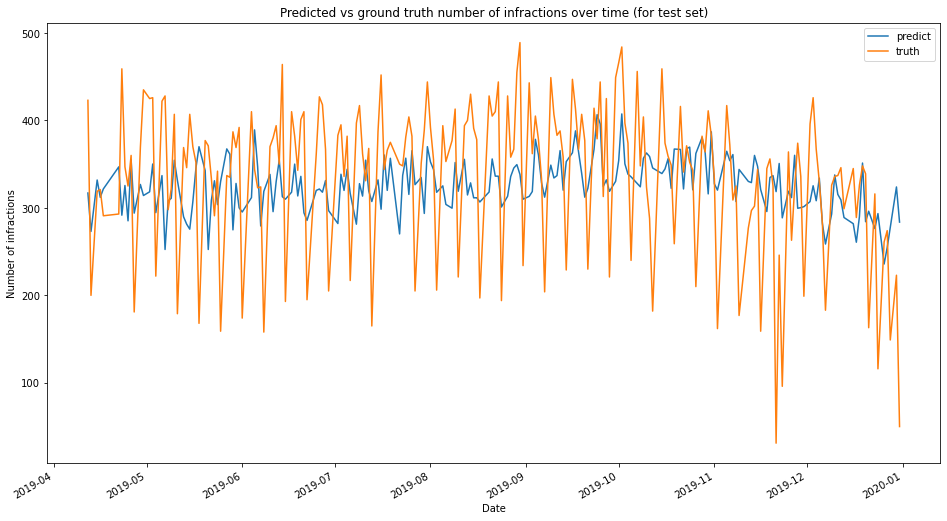

 ------------------ NODE 36 TRUTH VS PREDICTED CHECK INS ------------------ 


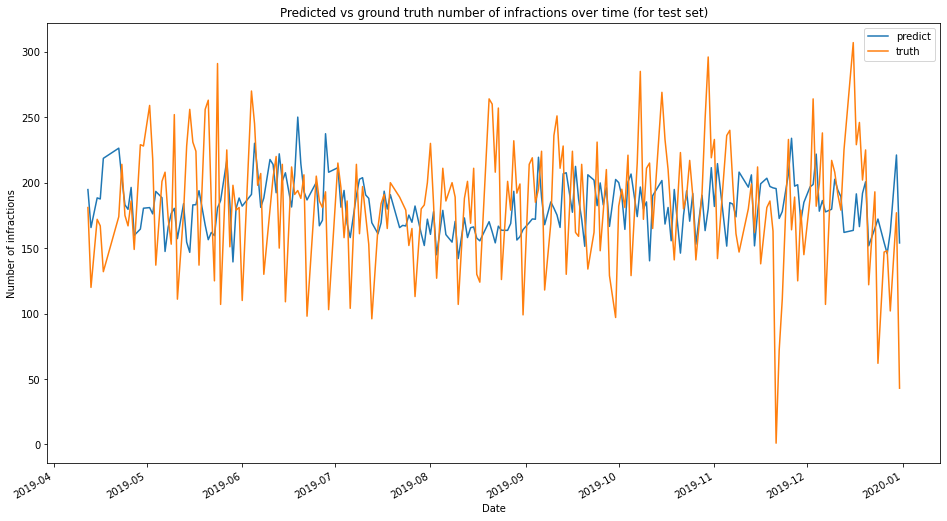

 ------------------ NODE 22 TRUTH VS PREDICTED CHECK INS ------------------ 


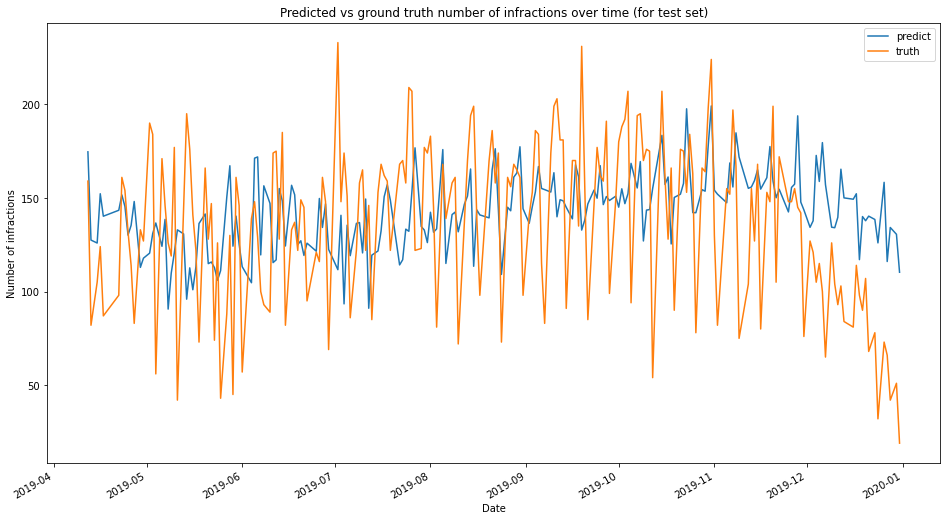

 ------------------ NODE 19 TRUTH VS PREDICTED CHECK INS ------------------ 


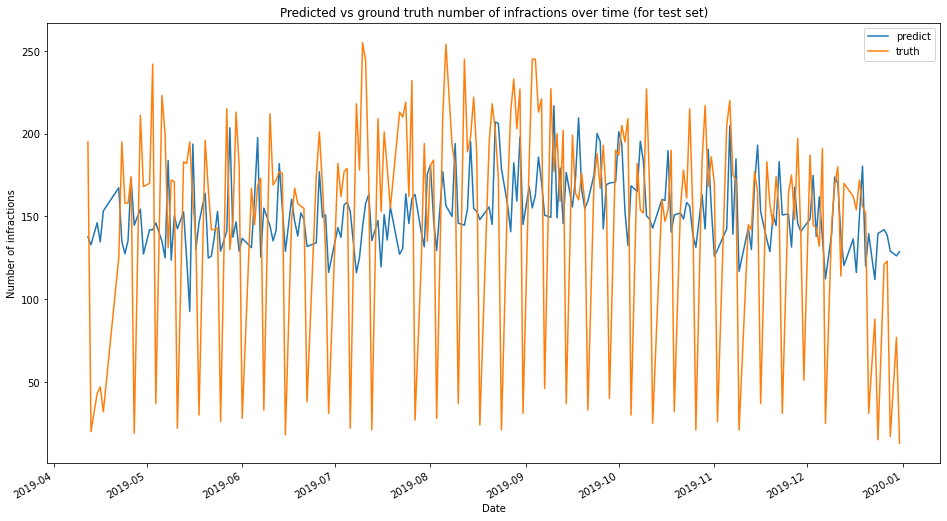

 ------------------ NODE 21 TRUTH VS PREDICTED CHECK INS ------------------ 


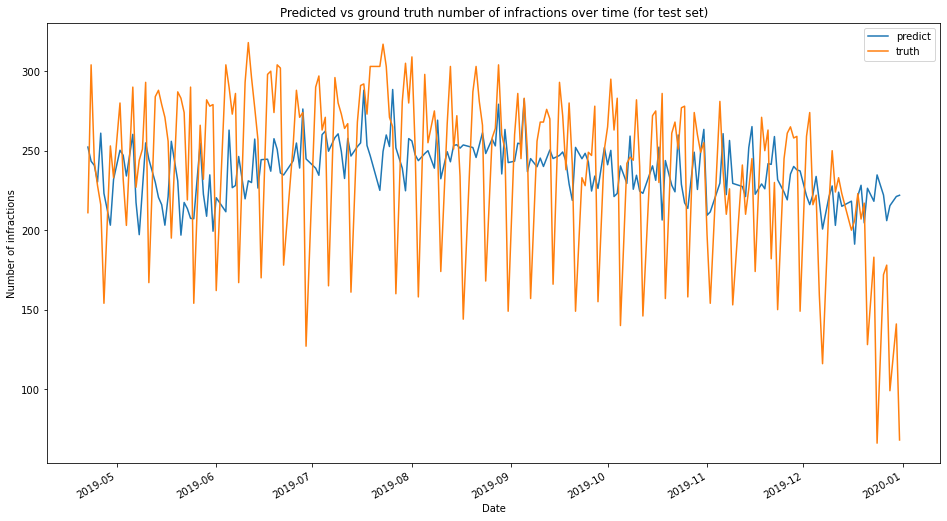

 ------------------ NODE 47 TRUTH VS PREDICTED CHECK INS ------------------ 


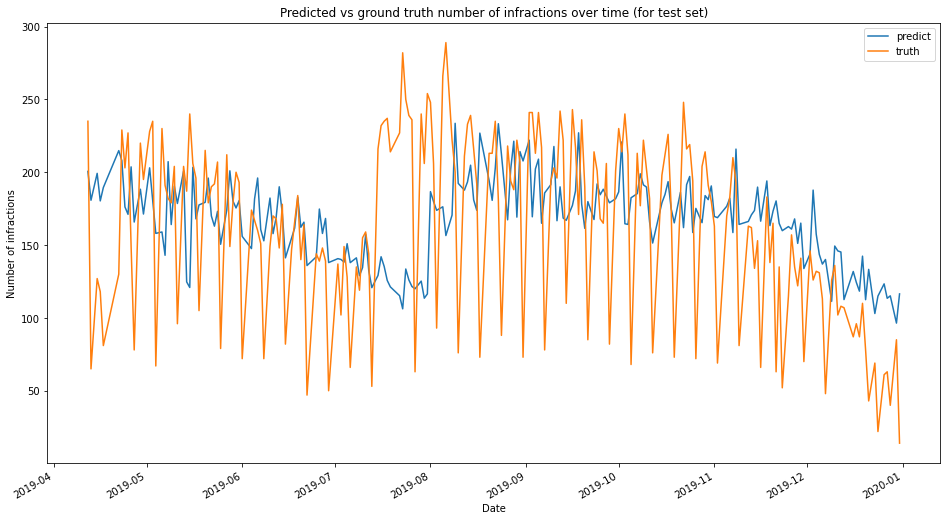

 ------------------ NODE 45 TRUTH VS PREDICTED CHECK INS ------------------ 


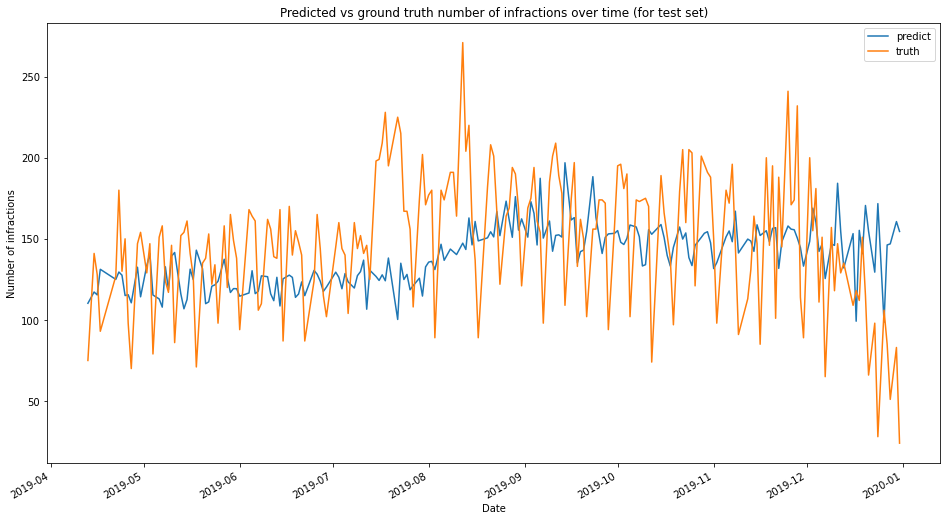

 ------------------ NODE 46 TRUTH VS PREDICTED CHECK INS ------------------ 


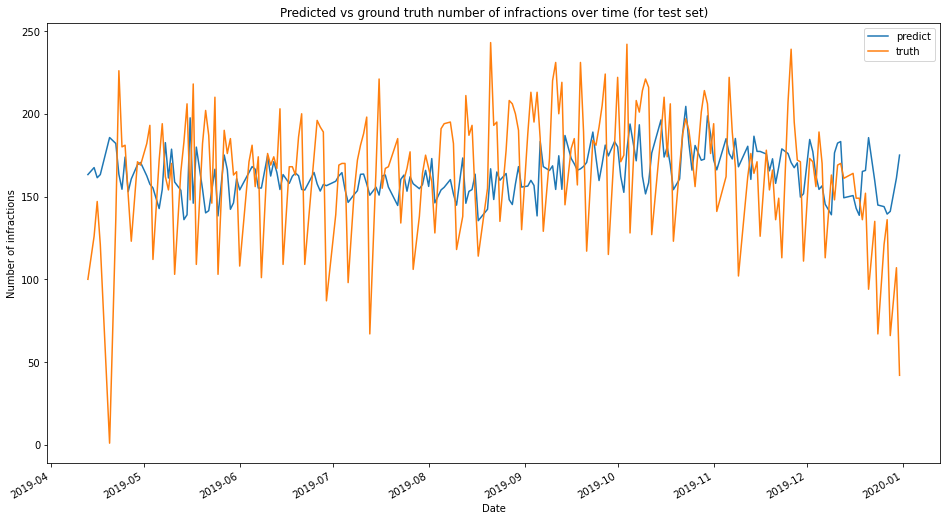

 ------------------ NODE 65 TRUTH VS PREDICTED CHECK INS ------------------ 


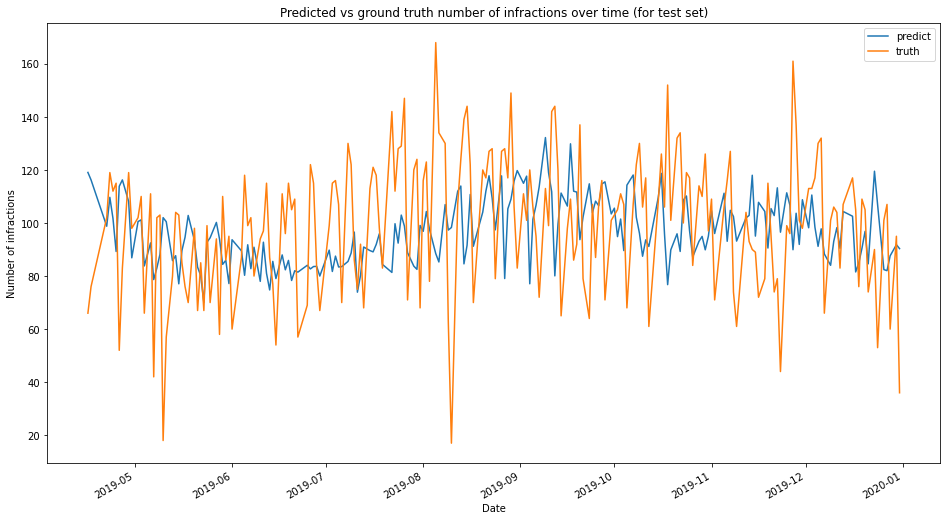

 ------------------ NODE 39 TRUTH VS PREDICTED CHECK INS ------------------ 


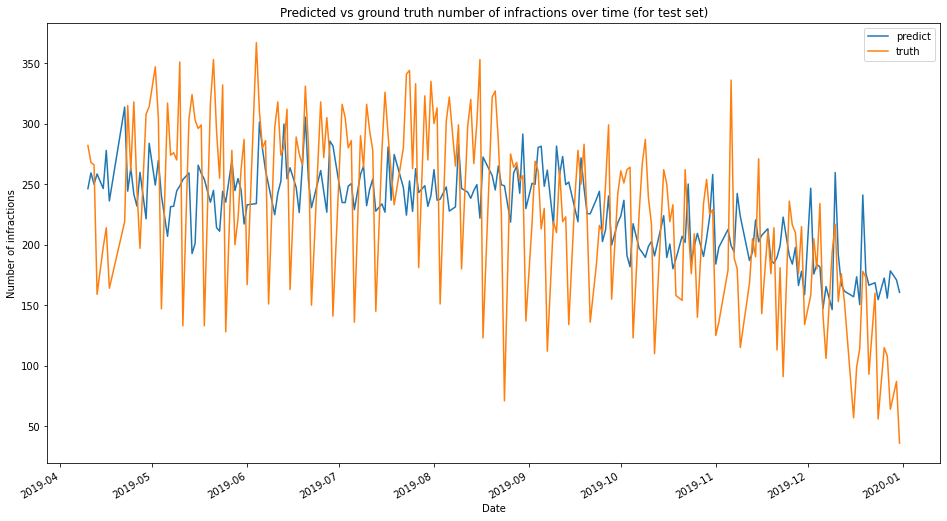

 ------------------ NODE 55 TRUTH VS PREDICTED CHECK INS ------------------ 


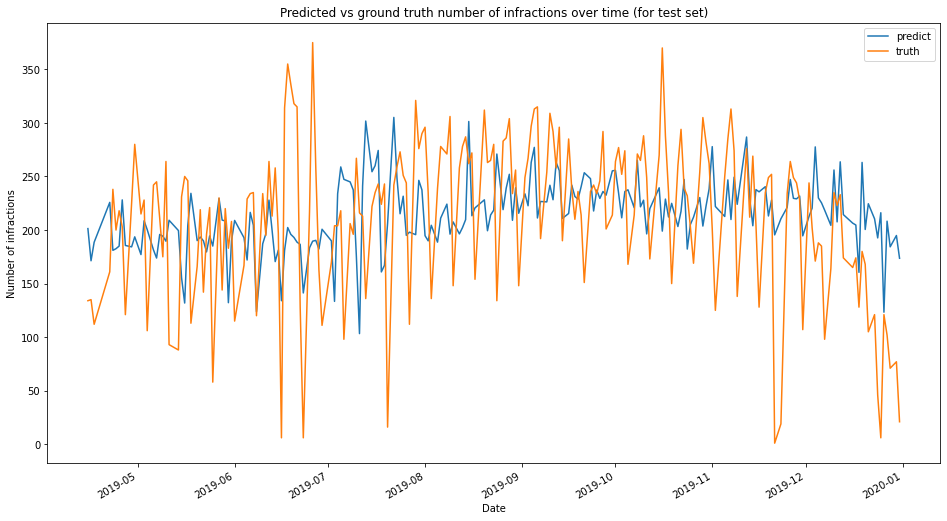

 ------------------ NODE 11 TRUTH VS PREDICTED CHECK INS ------------------ 


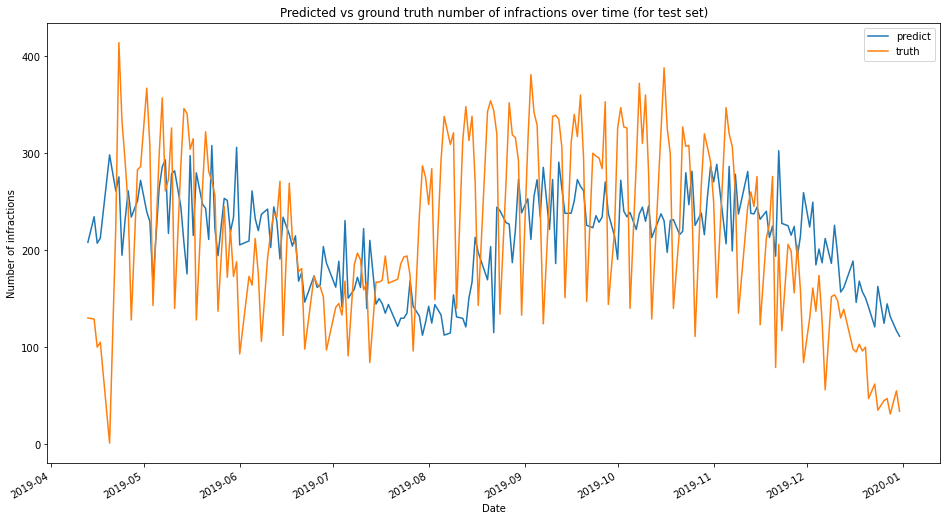

 ------------------ NODE 44 TRUTH VS PREDICTED CHECK INS ------------------ 


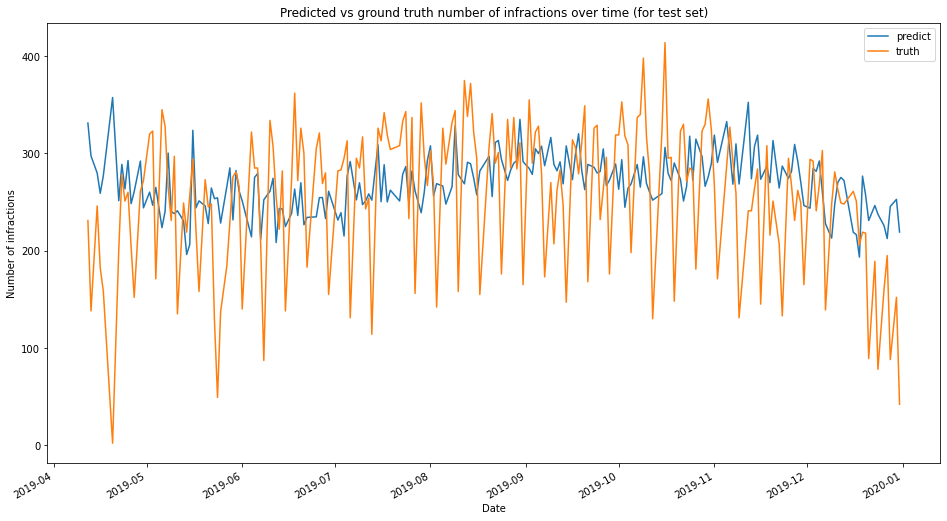

 ------------------ NODE 2 TRUTH VS PREDICTED CHECK INS ------------------ 


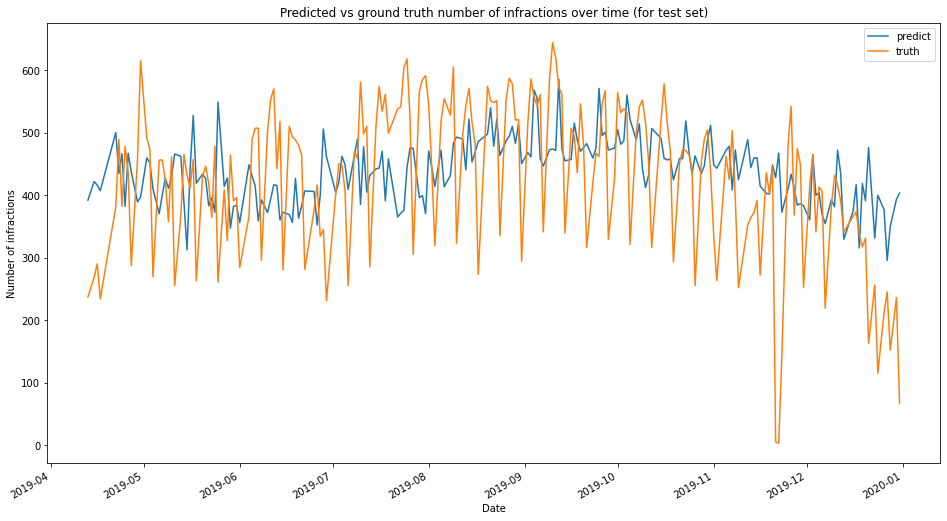

 ------------------ NODE 62 TRUTH VS PREDICTED CHECK INS ------------------ 


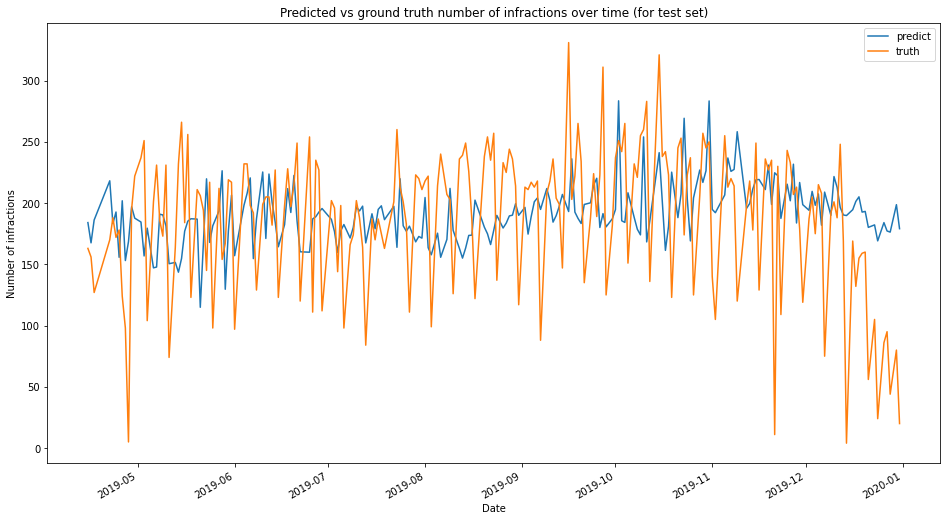

 ------------------ NODE 10 TRUTH VS PREDICTED CHECK INS ------------------ 


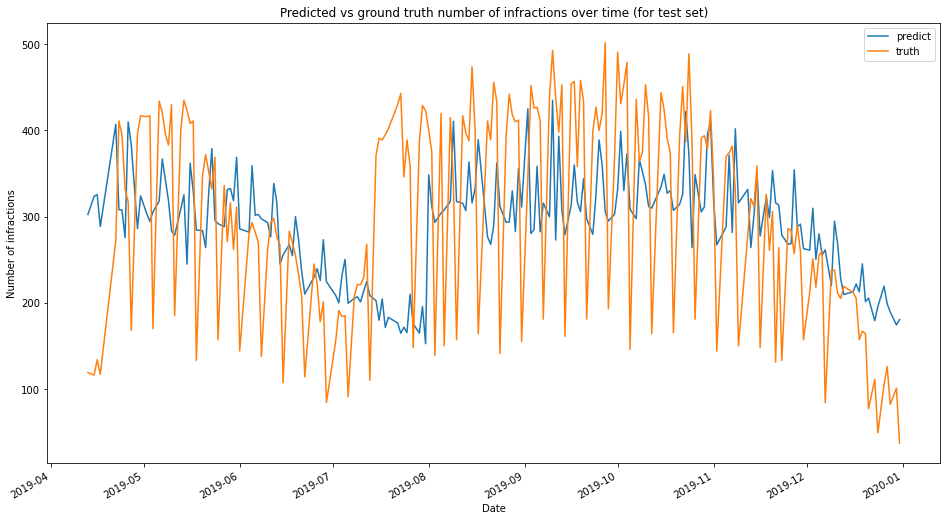

 ------------------ NODE 3 TRUTH VS PREDICTED CHECK INS ------------------ 


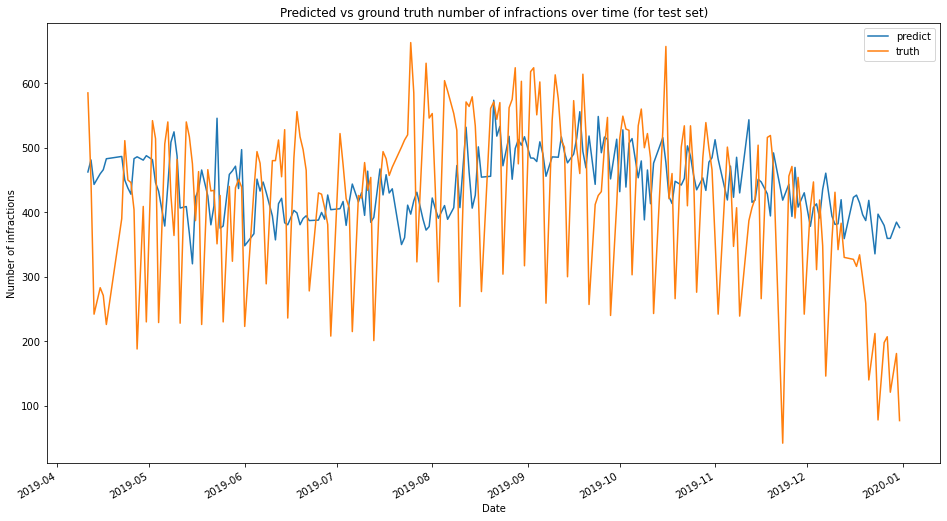

 ------------------ NODE 34 TRUTH VS PREDICTED CHECK INS ------------------ 


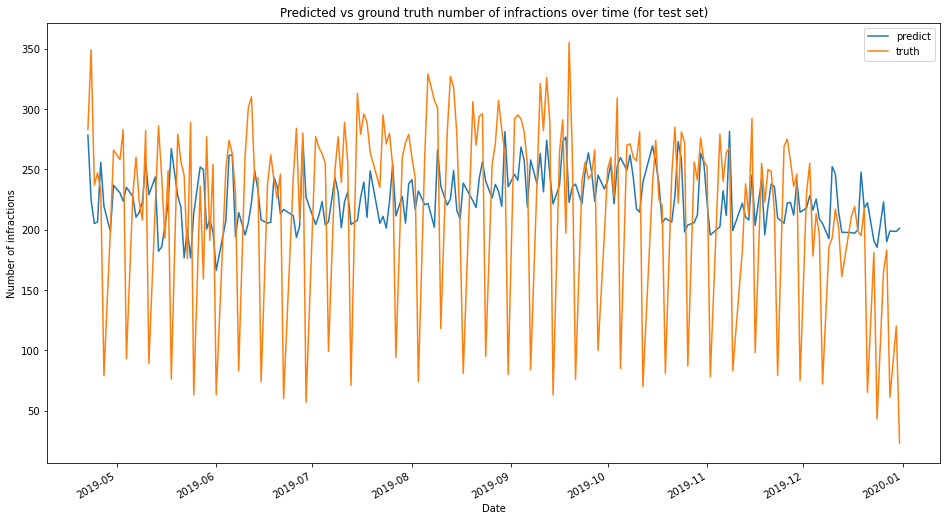

 ------------------ NODE 41 TRUTH VS PREDICTED CHECK INS ------------------ 


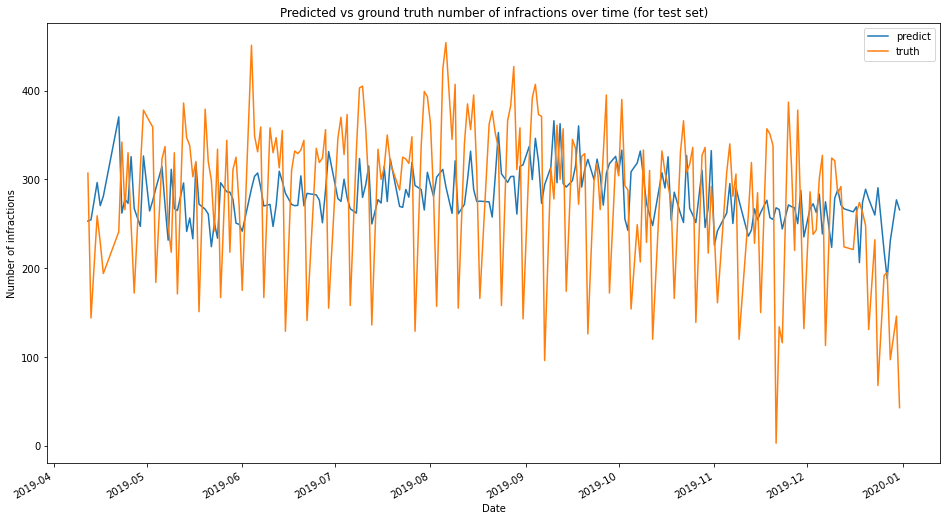

 ------------------ NODE 6 TRUTH VS PREDICTED CHECK INS ------------------ 


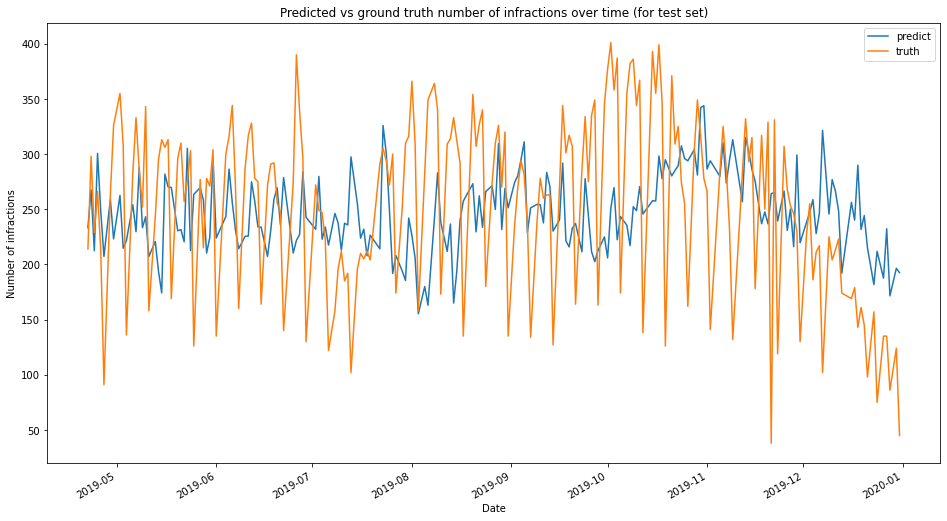

 ------------------ NODE 43 TRUTH VS PREDICTED CHECK INS ------------------ 


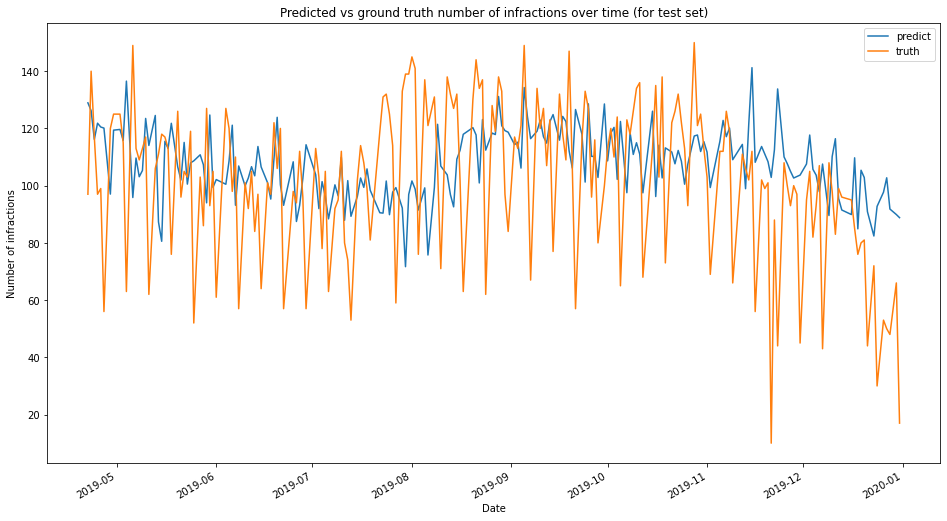

 ------------------ NODE 58 TRUTH VS PREDICTED CHECK INS ------------------ 


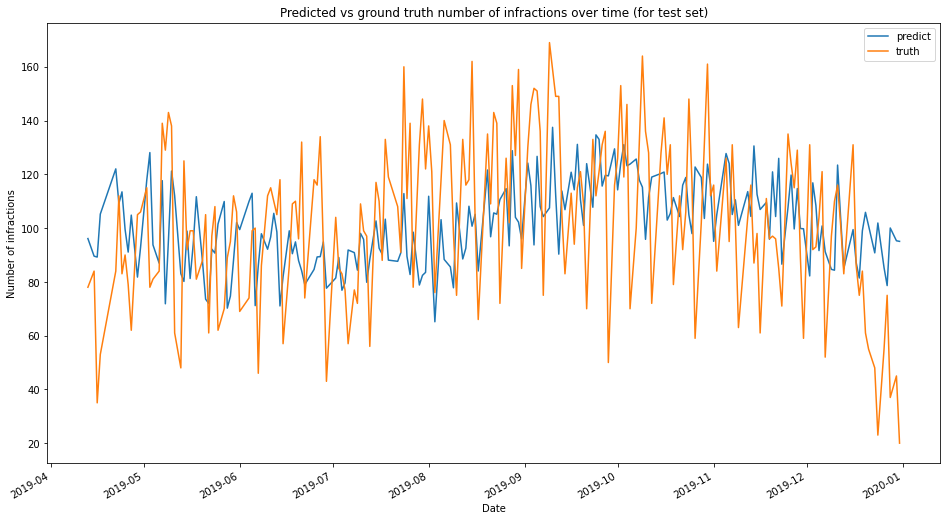

 ------------------ NODE 38 TRUTH VS PREDICTED CHECK INS ------------------ 


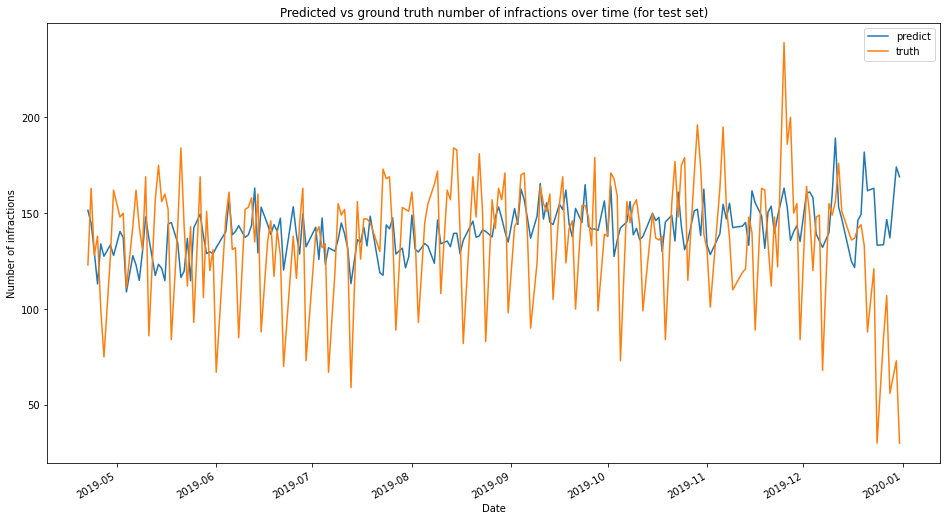

 ------------------ NODE 7 TRUTH VS PREDICTED CHECK INS ------------------ 


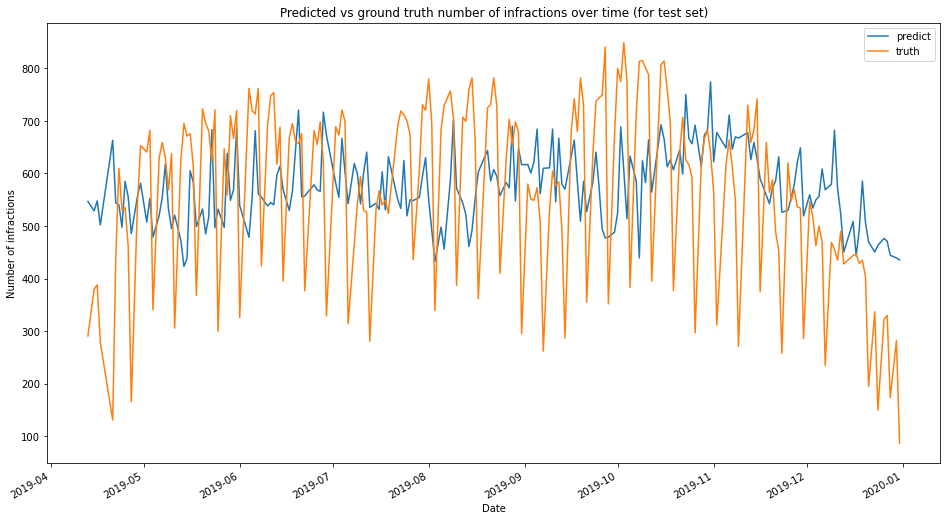

 ------------------ NODE 67 TRUTH VS PREDICTED CHECK INS ------------------ 


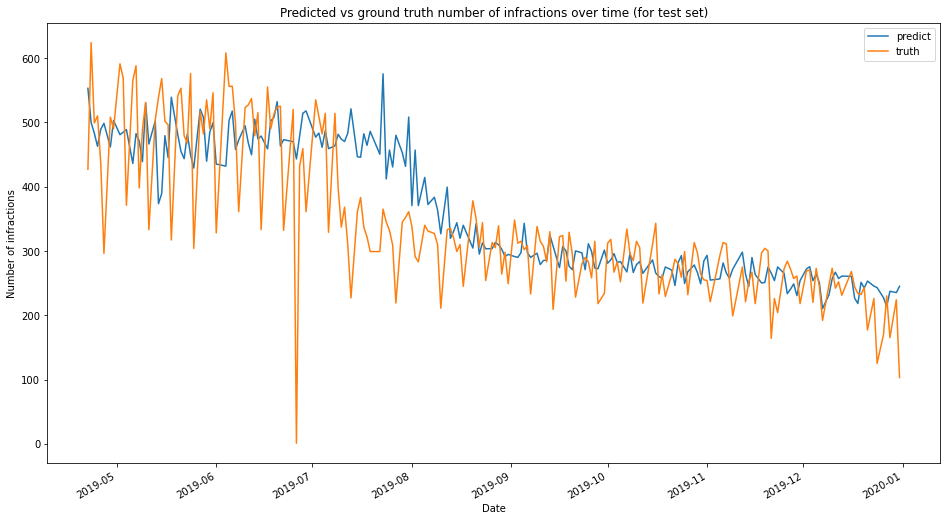

 ------------------ NODE 13 TRUTH VS PREDICTED CHECK INS ------------------ 


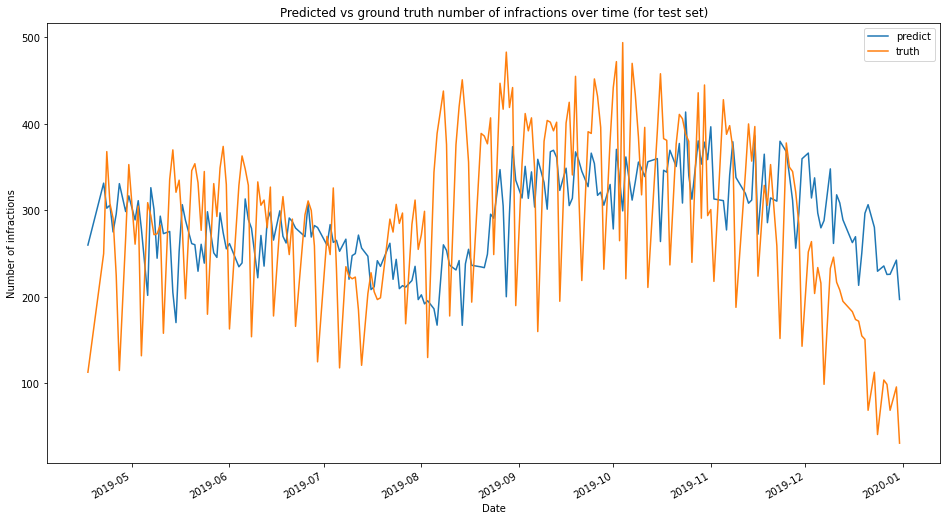

 ------------------ NODE 60 TRUTH VS PREDICTED CHECK INS ------------------ 


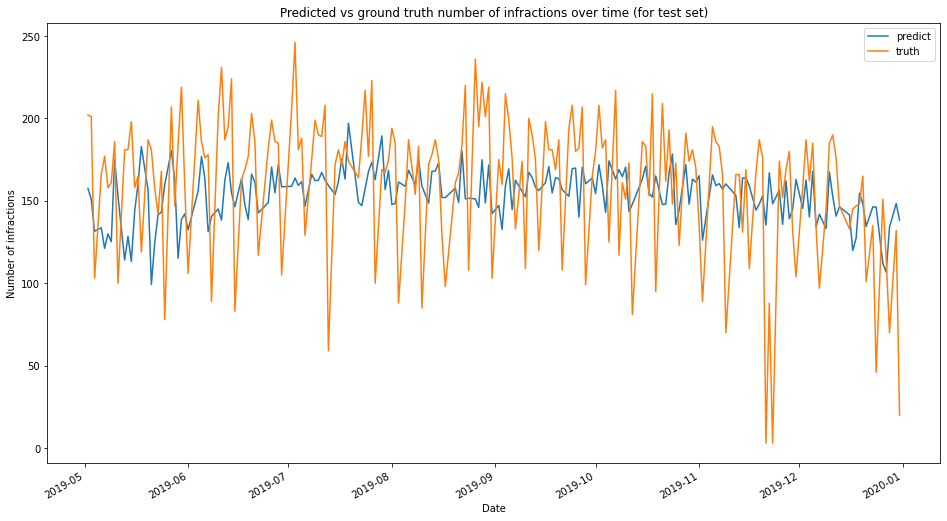

 ------------------ NODE 23 TRUTH VS PREDICTED CHECK INS ------------------ 


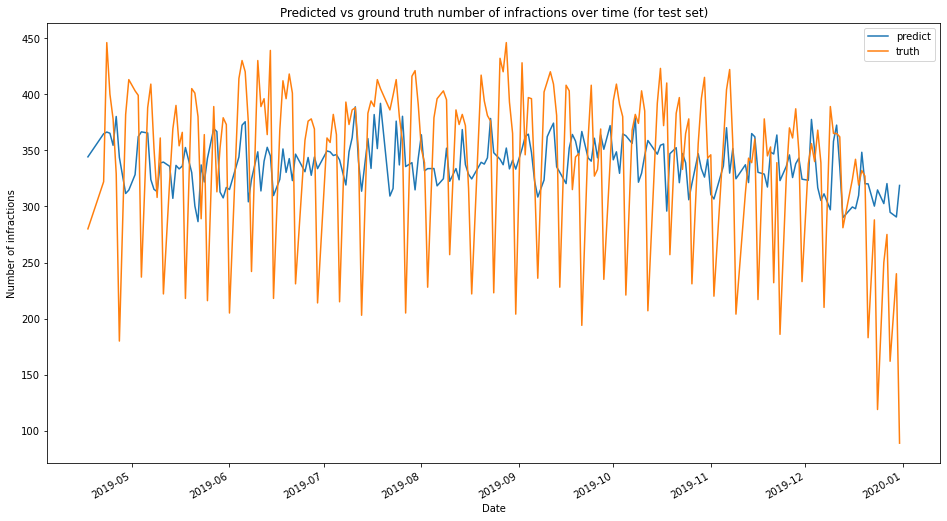

 ------------------ NODE 40 TRUTH VS PREDICTED CHECK INS ------------------ 


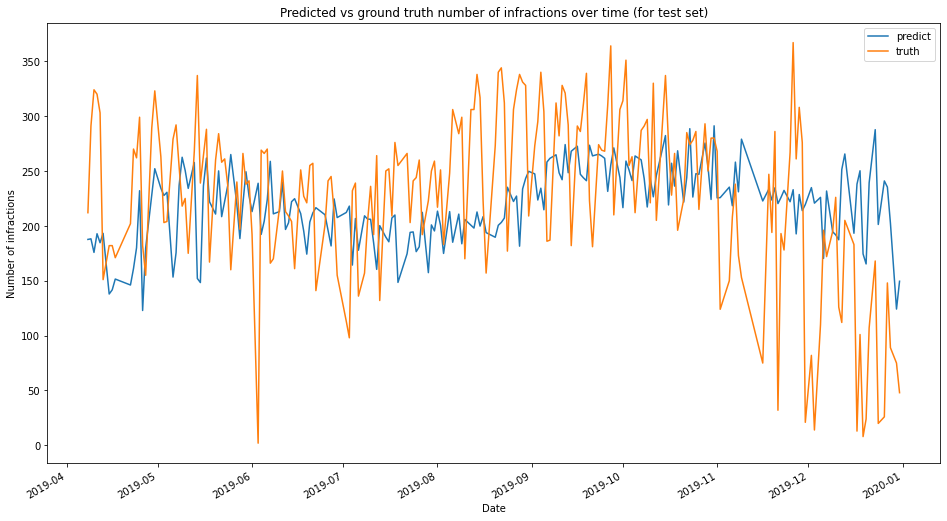

 ------------------ NODE 63 TRUTH VS PREDICTED CHECK INS ------------------ 


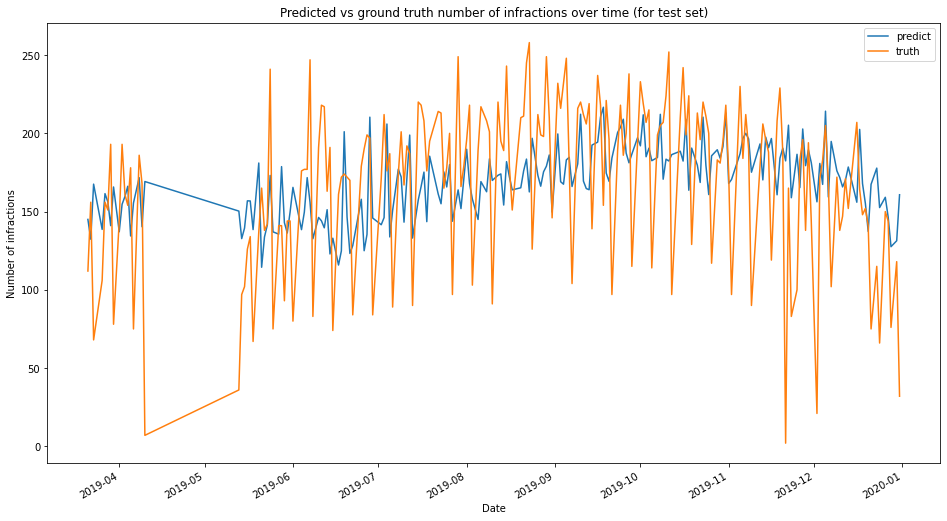

 ------------------ NODE 66 TRUTH VS PREDICTED CHECK INS ------------------ 


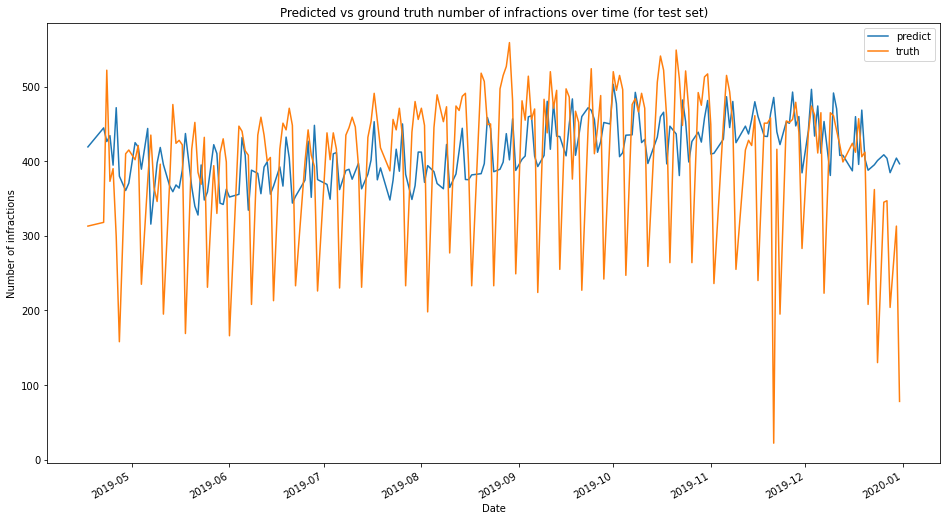

 ------------------ NODE 1 TRUTH VS PREDICTED CHECK INS ------------------ 


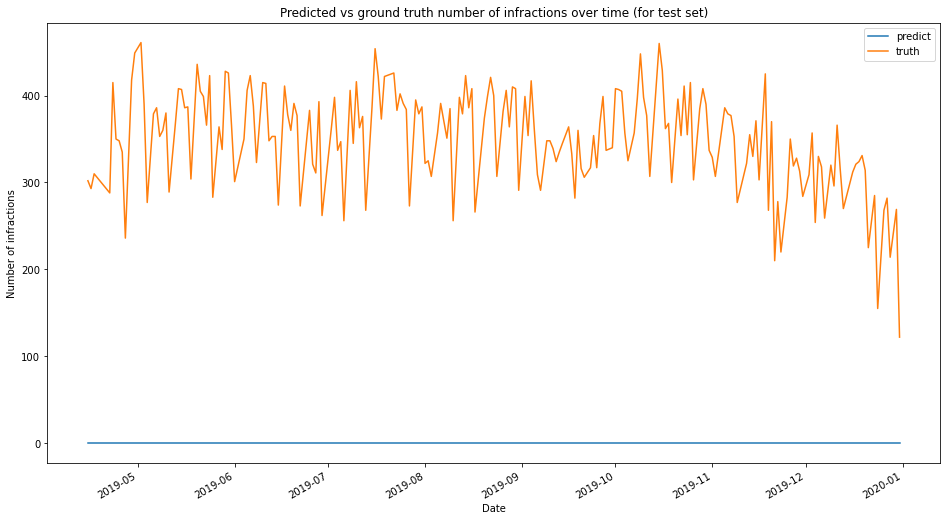

 ------------------ NODE 4 TRUTH VS PREDICTED CHECK INS ------------------ 


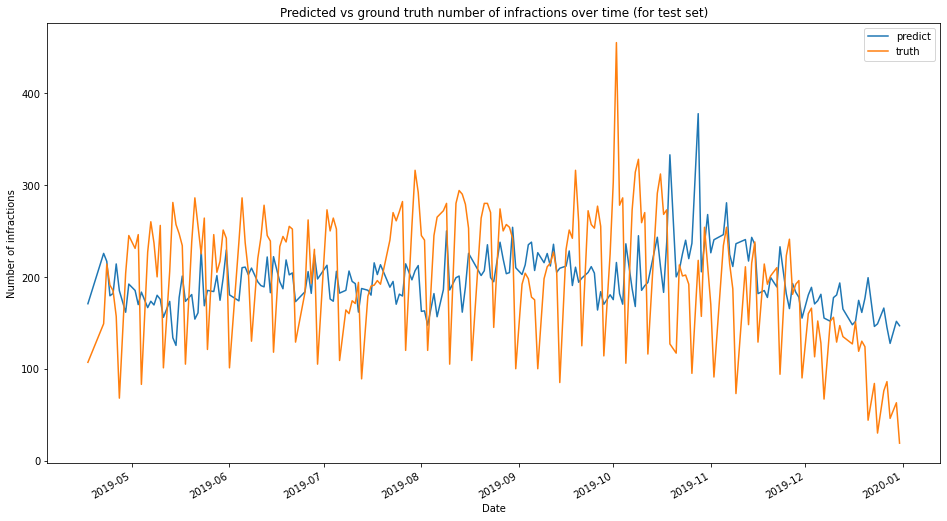

 ------------------ NODE 9 TRUTH VS PREDICTED CHECK INS ------------------ 


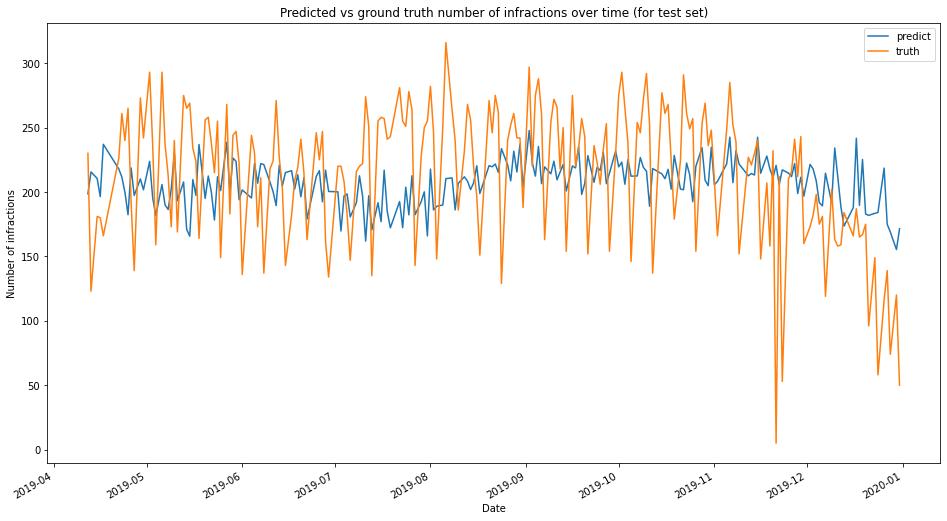

 ------------------ NODE 51 TRUTH VS PREDICTED CHECK INS ------------------ 


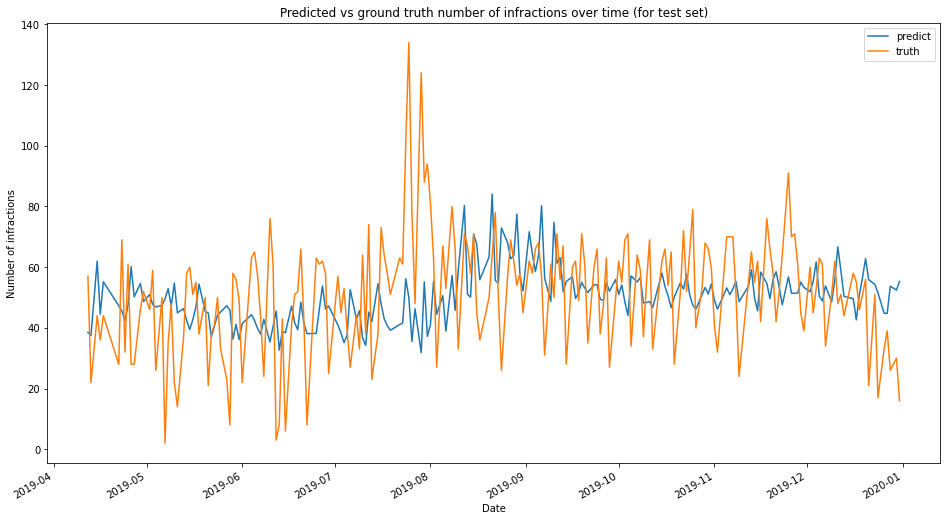

 ------------------ NODE 12 TRUTH VS PREDICTED CHECK INS ------------------ 


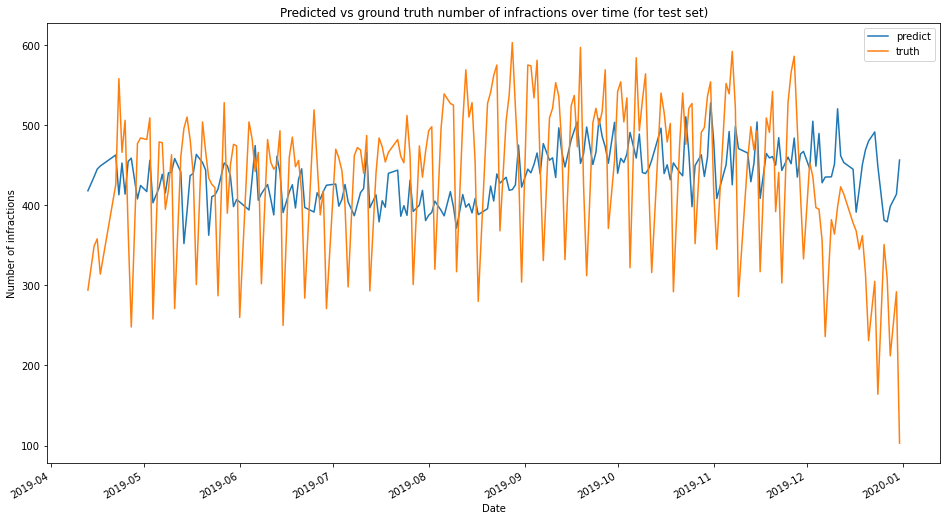

 ------------------ NODE 70 TRUTH VS PREDICTED CHECK INS ------------------ 


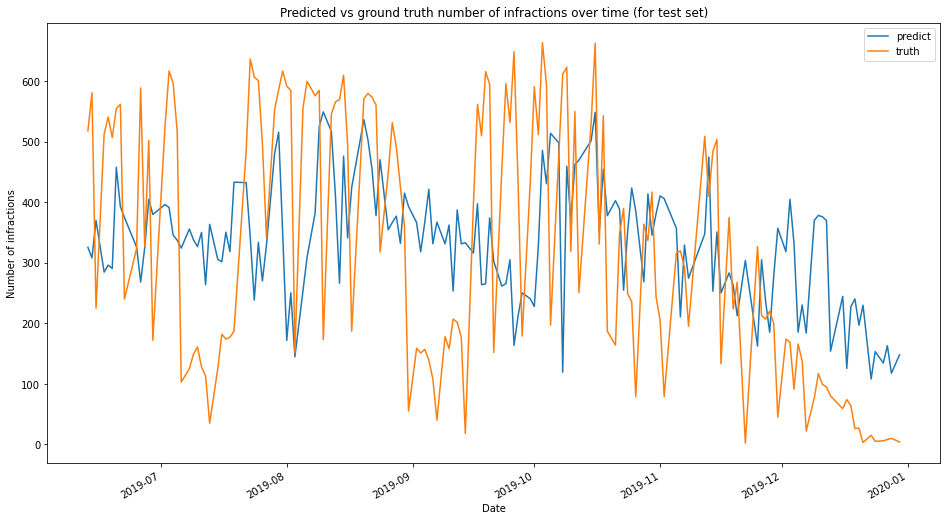

 ------------------ NODE 69 TRUTH VS PREDICTED CHECK INS ------------------ 


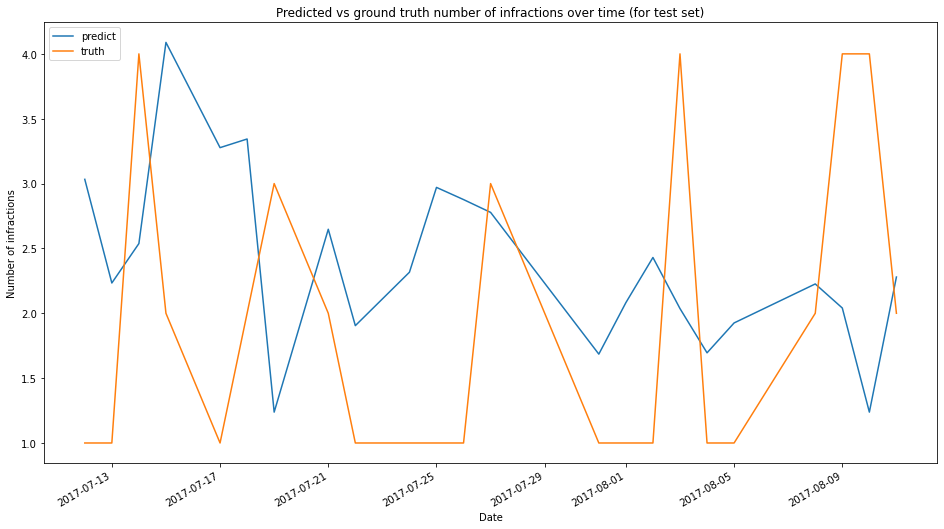

 ------------------ NODE 24 TRUTH VS PREDICTED CHECK INS ------------------ 


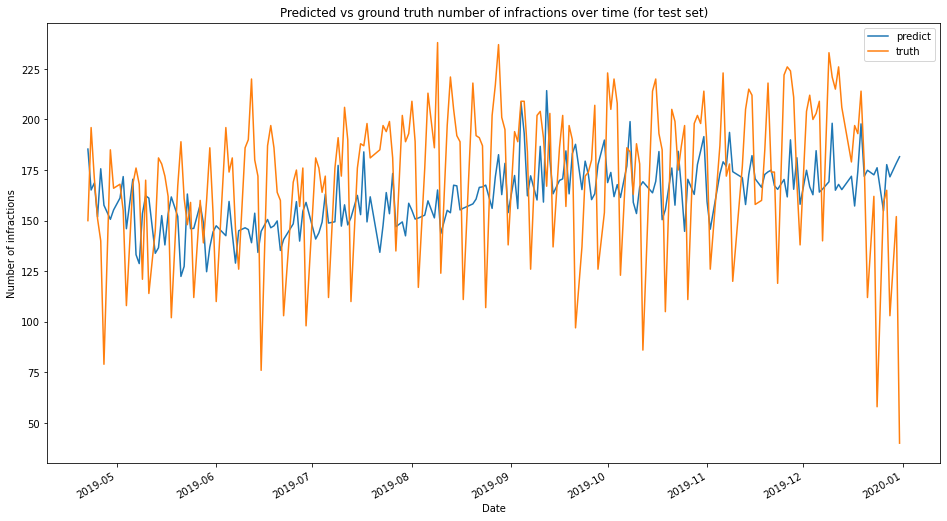

 ------------------ NODE 16 TRUTH VS PREDICTED CHECK INS ------------------ 


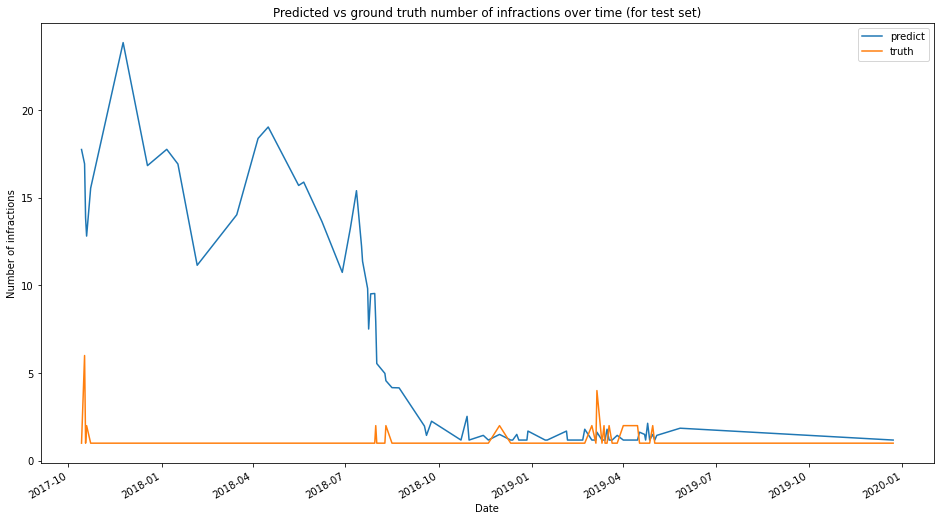

 ------------------ NODE 64 TRUTH VS PREDICTED CHECK INS ------------------ 


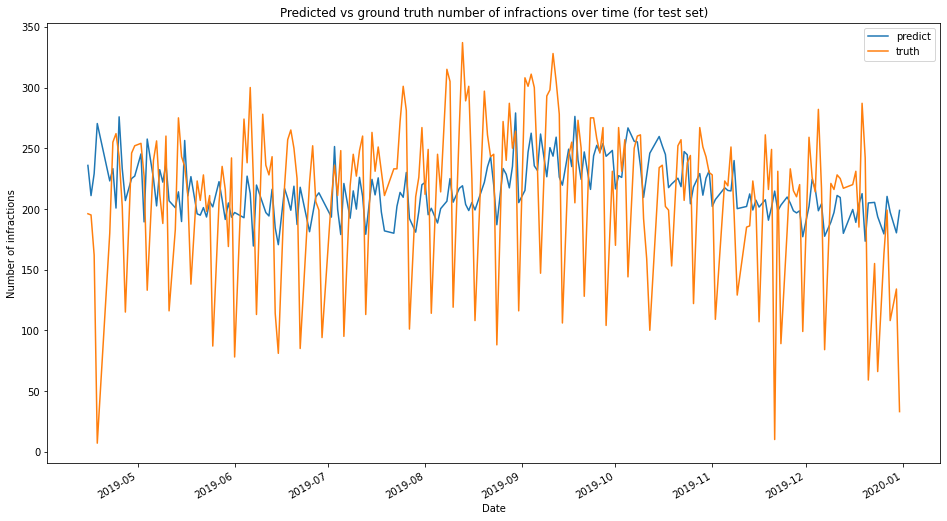

 ------------------ NODE 59 TRUTH VS PREDICTED CHECK INS ------------------ 


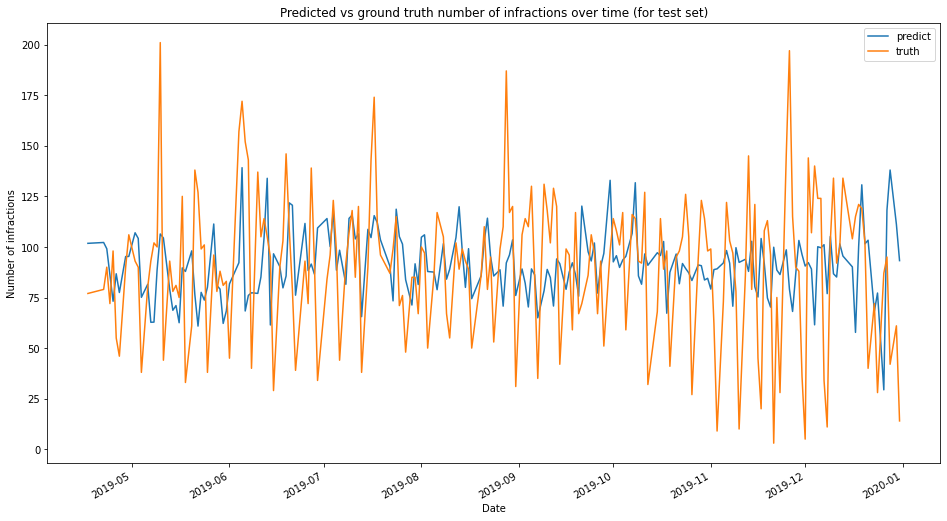

 ------------------ NODE 33 TRUTH VS PREDICTED CHECK INS ------------------ 


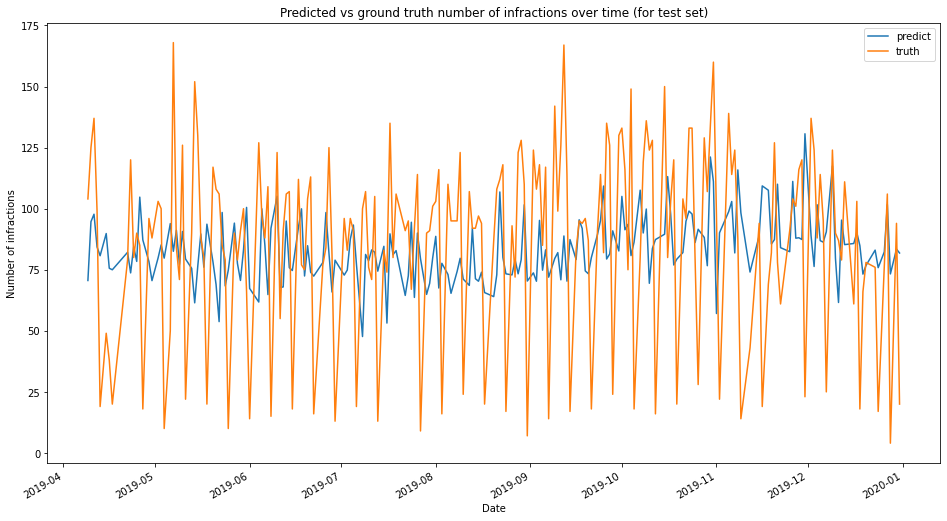

 ------------------ NODE 42 TRUTH VS PREDICTED CHECK INS ------------------ 


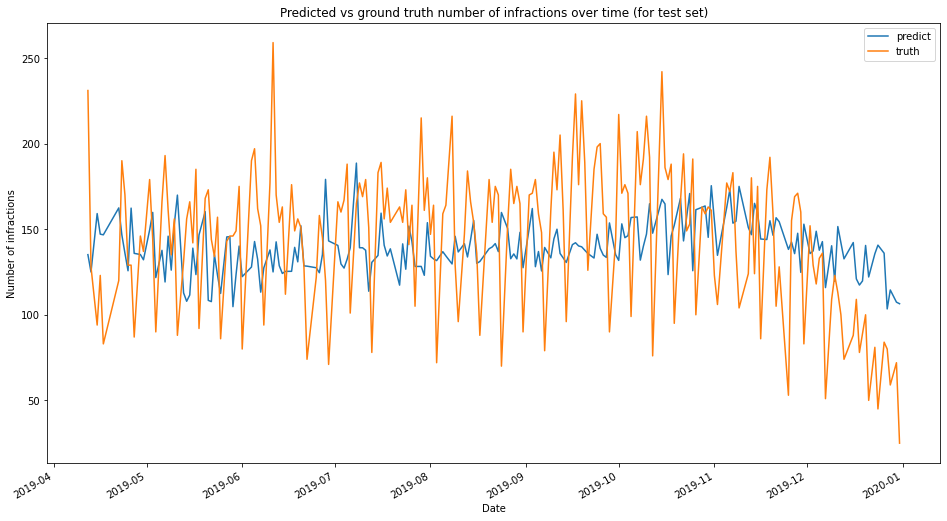

 ------------------ NODE 57 TRUTH VS PREDICTED CHECK INS ------------------ 


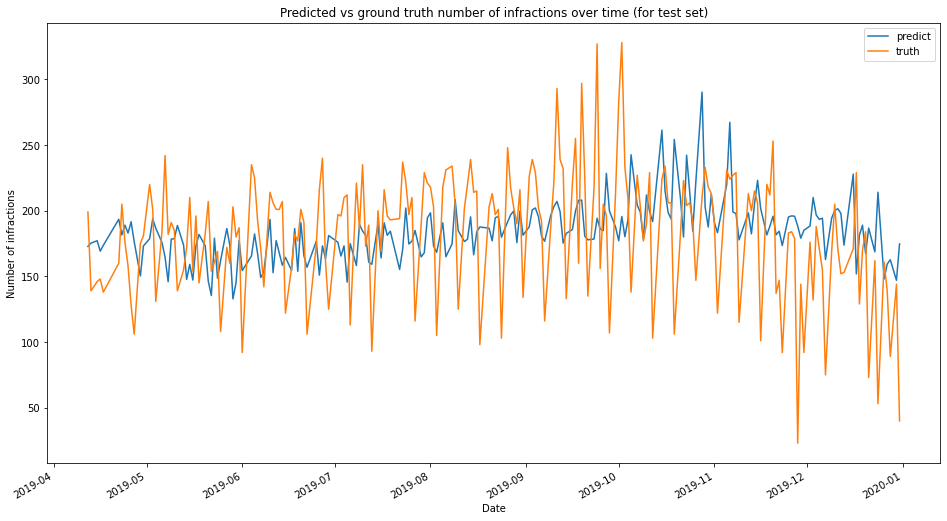

 ------------------ NODE 27 TRUTH VS PREDICTED CHECK INS ------------------ 


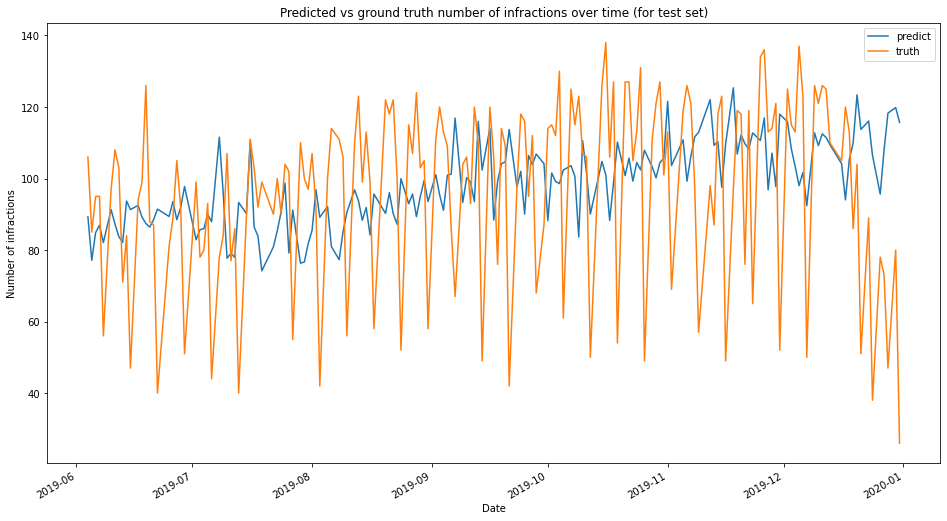

 ------------------ NODE 61 TRUTH VS PREDICTED CHECK INS ------------------ 


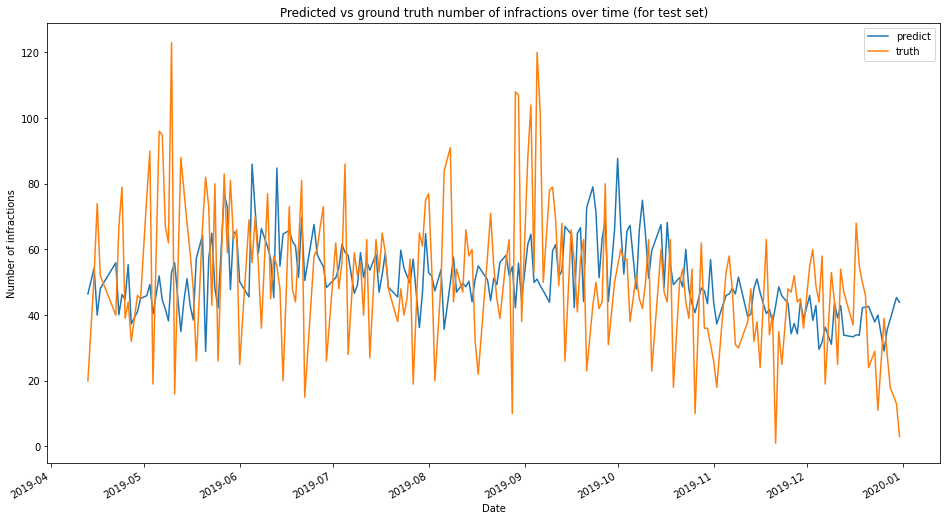

 ------------------ NODE 48 TRUTH VS PREDICTED CHECK INS ------------------ 


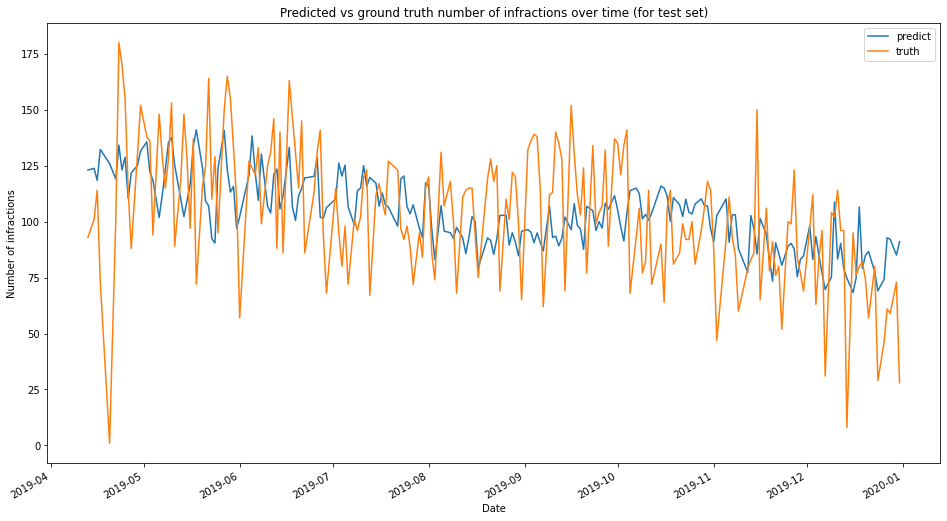

 ------------------ NODE 20 TRUTH VS PREDICTED CHECK INS ------------------ 


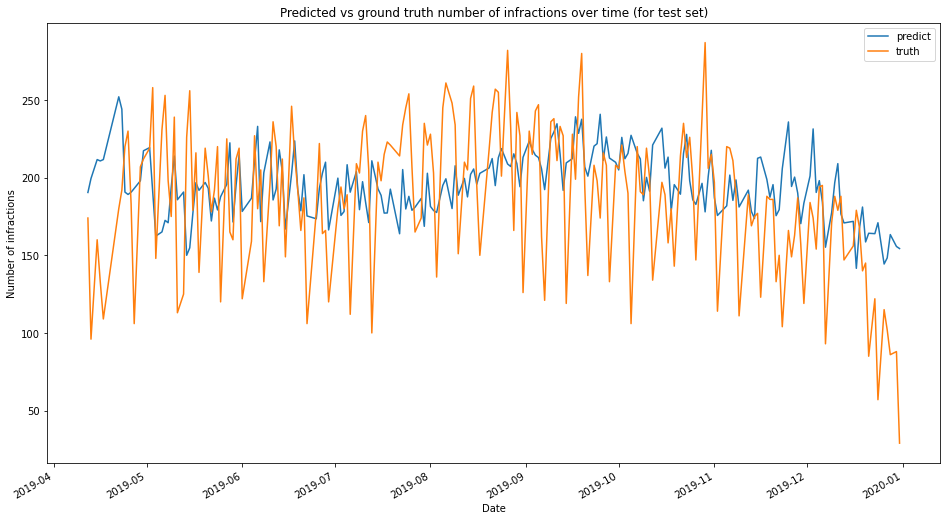

 ------------------ NODE 35 TRUTH VS PREDICTED CHECK INS ------------------ 


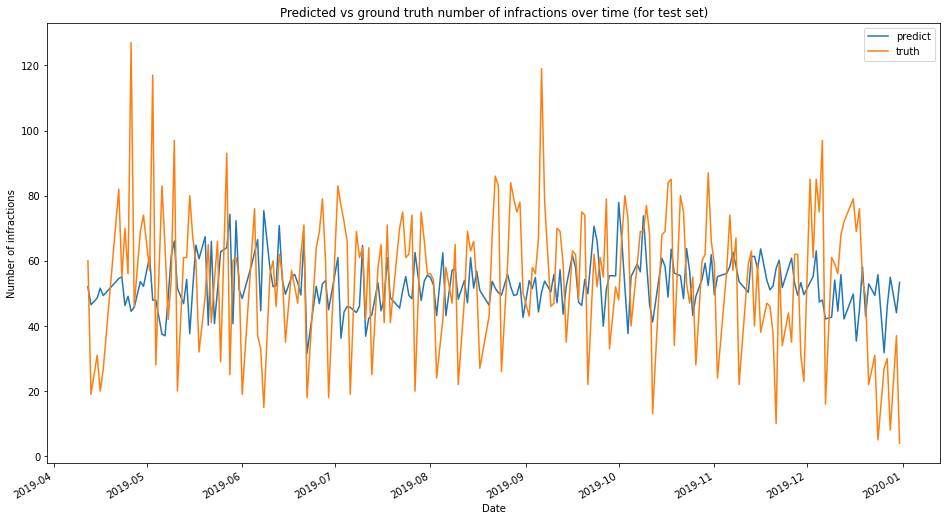

 ------------------ NODE 37 TRUTH VS PREDICTED CHECK INS ------------------ 


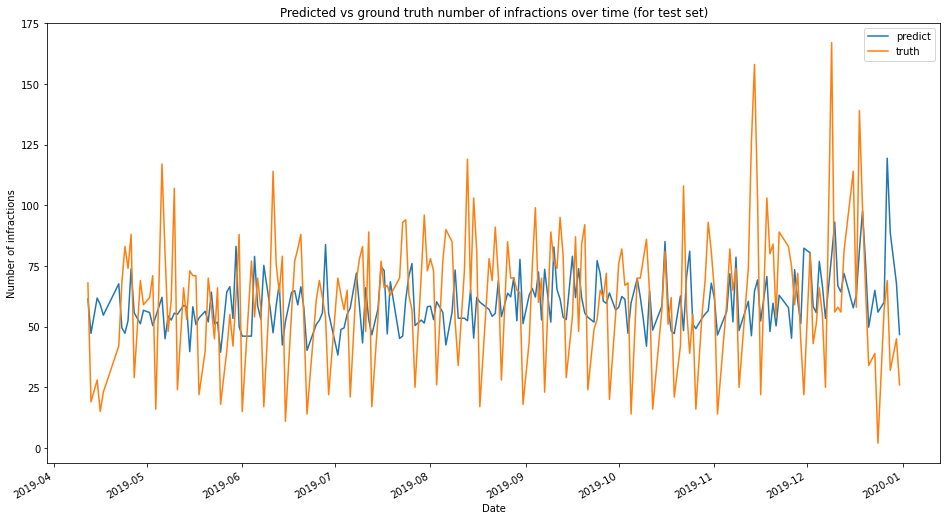

 ------------------ NODE 5 TRUTH VS PREDICTED CHECK INS ------------------ 


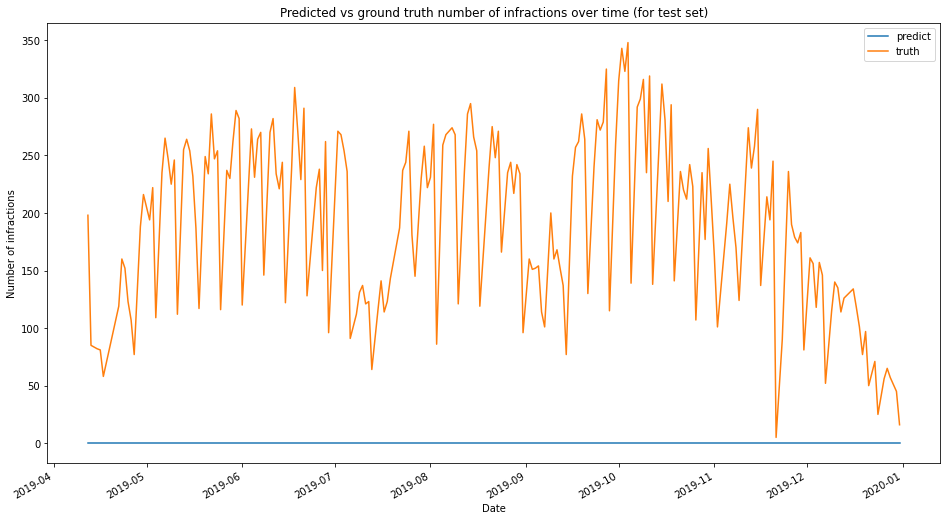

 ------------------ NODE 32 TRUTH VS PREDICTED CHECK INS ------------------ 


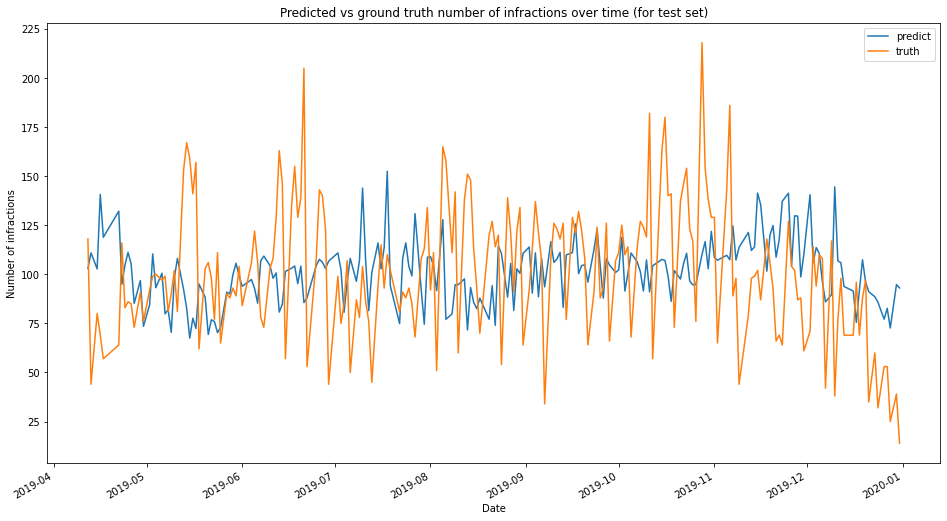

 ------------------ NODE 49 TRUTH VS PREDICTED CHECK INS ------------------ 


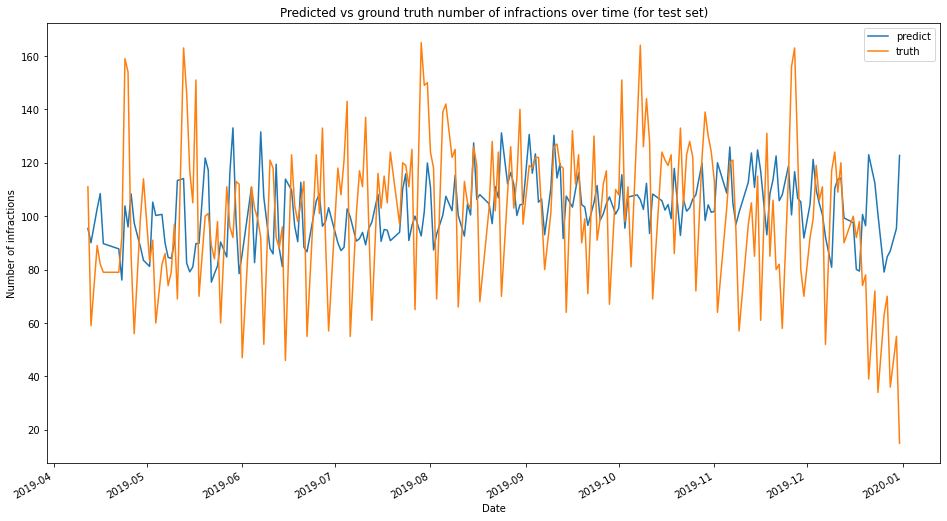

 ------------------ NODE 54 TRUTH VS PREDICTED CHECK INS ------------------ 


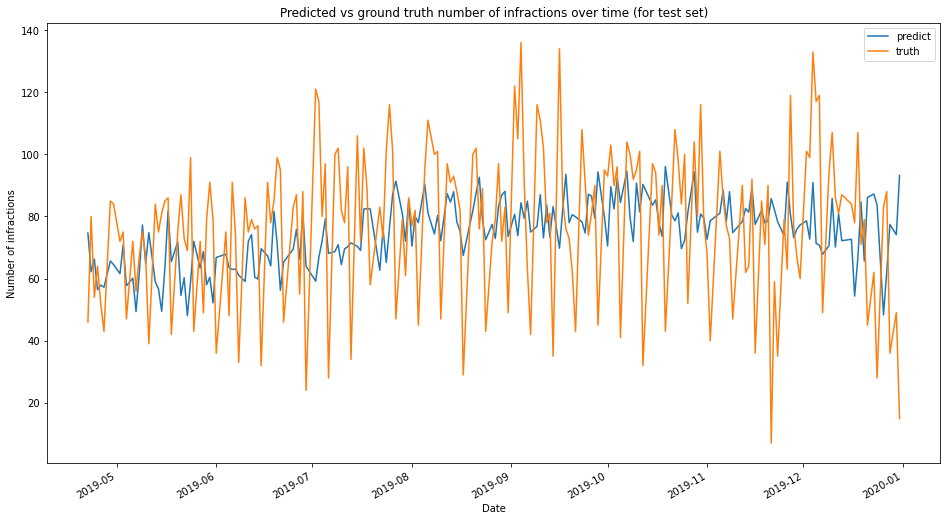

 ------------------ NODE 28 TRUTH VS PREDICTED CHECK INS ------------------ 


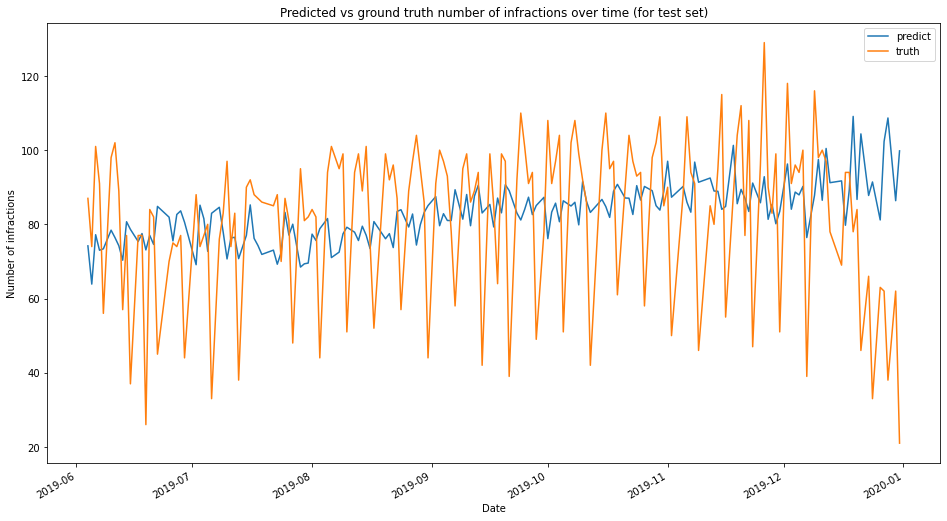

 ------------------ NODE 53 TRUTH VS PREDICTED CHECK INS ------------------ 


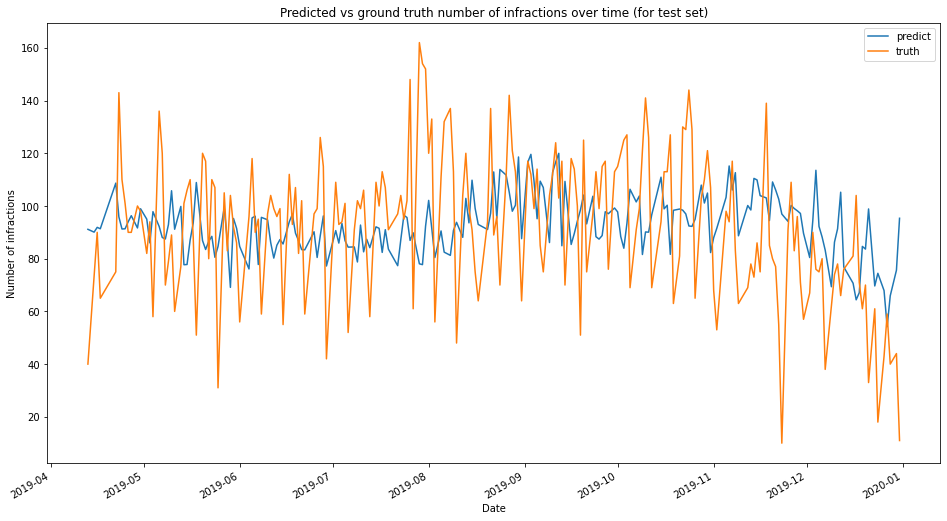

 ------------------ NODE 17 TRUTH VS PREDICTED CHECK INS ------------------ 


KeyError: 17

In [39]:
rms = np.sqrt(mean_squared_error(allNodesDf["truth"], allNodesDf["predict"]))
print ("OVERALL ROOT MEAN SQUARED ERROR >> " + str(rms))

for node in unique_parks:
    print (" ------------------ NODE {} TRUTH VS PREDICTED CHECK INS ------------------ ".format(node))
    ax=allNodesDf.loc[node].plot(figsize=(16,9), title='Predicted vs ground truth number of infractions over time (for test set)')

    ax.set_xlabel("Date")
    ax.set_ylabel("Number of infractions")
    plt.show()